In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import pickle
import os

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Preprocessing

## Dataset creation

In [3]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [4]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

## Fluorprobe exploration

In [5]:
fp_df['depth_discrete'] = fp_df['depth'].apply(lambda x: min(biomass_by_week_year_group['Depth'], key=lambda y: abs(y - x)))

## Splitting to test temporarily & Extracting probe's test data

In [52]:
biomass_test = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] >= 3)]
biomass_val = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] < 3)]
biomass_train = biomass_by_week_year_group[(~biomass_by_week_year_group.index.isin(biomass_test.index)) & (~biomass_by_week_year_group.index.isin(biomass_val.index))]

fp_test = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] >= 3)]
fp_val = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] < 3)]
fp_train = fp_df[(~fp_df.index.isin(fp_test.index)) & (~fp_df.index.isin(fp_val.index))]

merged_train = merge_fp_biomass_df(fp_train, biomass_train, is_train=True) # Merging fully
merged_val = merge_fp_biomass_df(fp_val, biomass_val, is_train=False) # Merging fully
merged_test = merge_fp_biomass_df(fp_test, biomass_test, is_train=False) # Merging only closest records by depth

In [53]:
merged_train = merged_train.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_val_df = merged_val[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_val = merged_val.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_test_df = merged_test[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_test = merged_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

In [54]:
biomass_estimation(merged_train)

# EDA and Cleaning

In [55]:
merged_train.shape

(55389, 18)

In [56]:
merged_train = merged_train[merged_train['sum_biomass_ug_ml'] >= 0]

In [57]:
merged_train.shape

(53332, 18)

In [58]:
merged_train.loc[merged_train['Depth'] >= 21, 'Depth'] = 21

In [59]:
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub', 'sum_biomass_ug_ml']

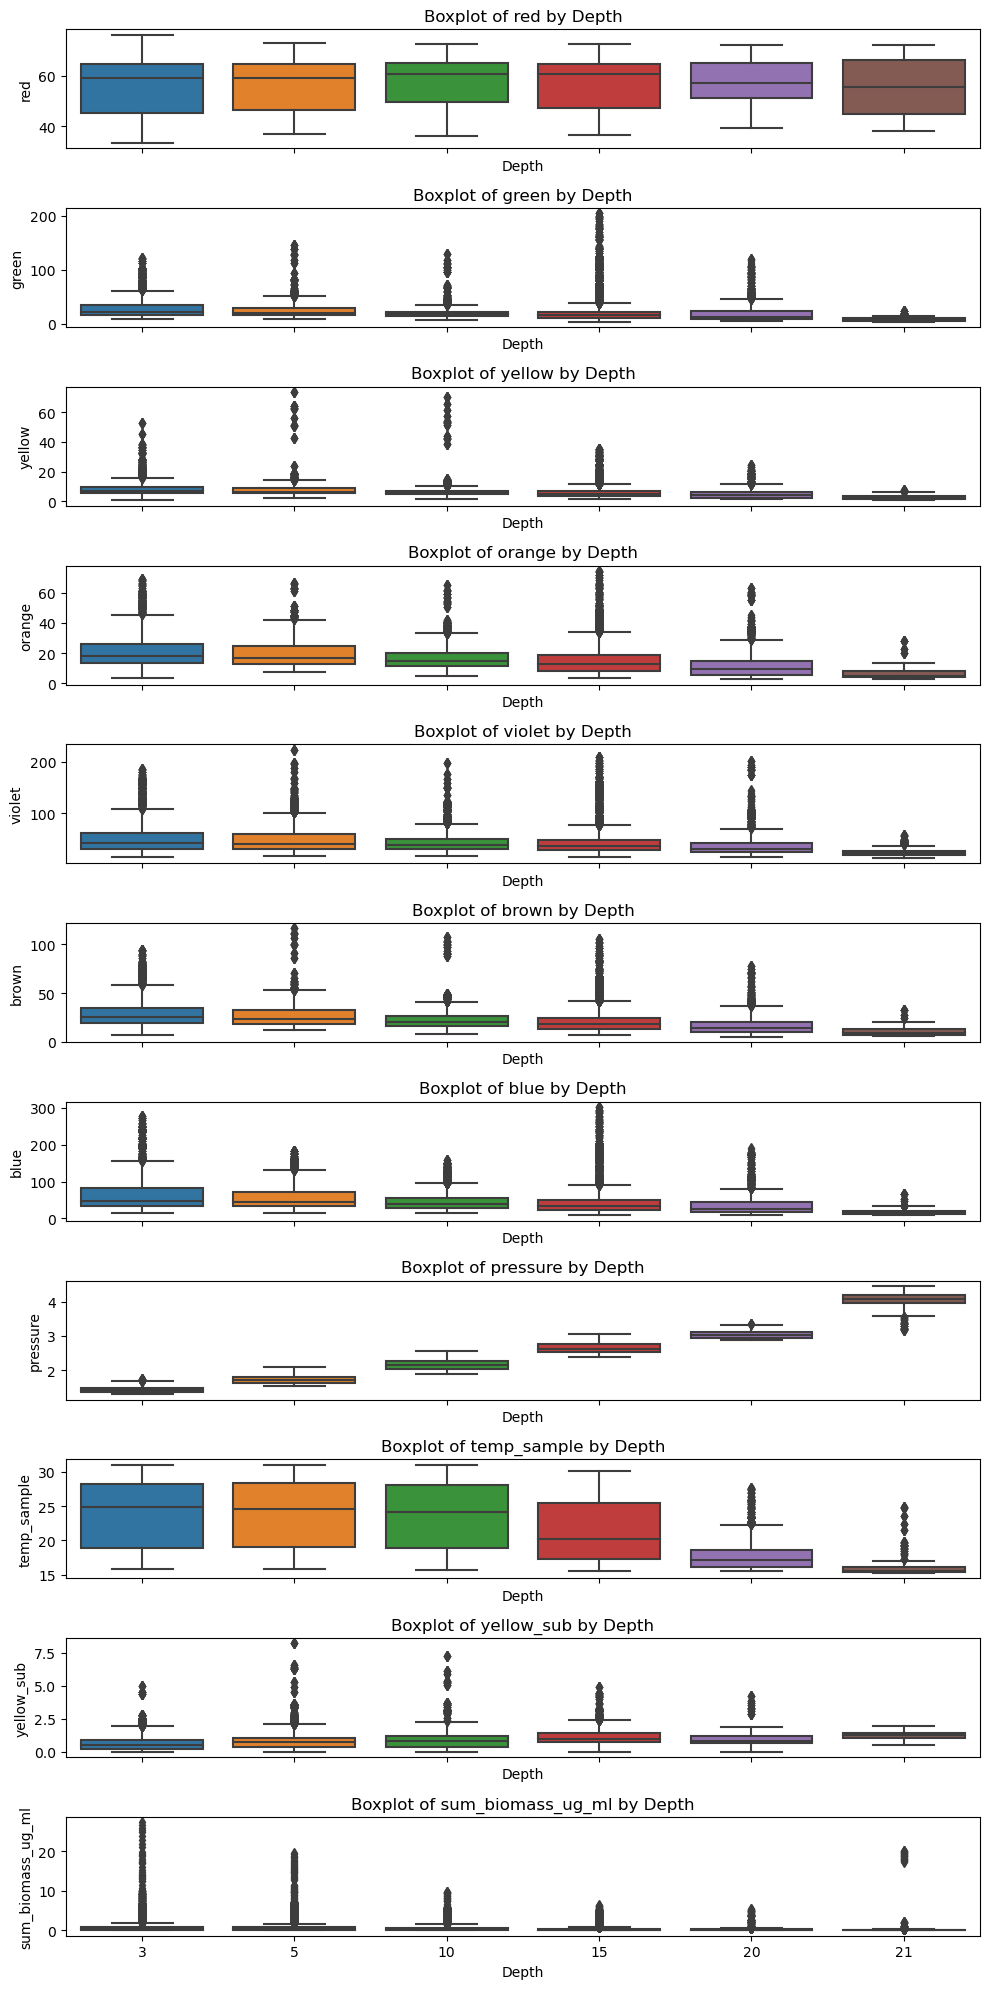

In [60]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

In [61]:
signals.remove('sum_biomass_ug_ml')
signals.remove('pressure')
signals.remove('temp_sample')
boundaries = {
    'red': {'lower_bound': 0, 'upper_bound': 120},
    'green': {'lower_bound': 0, 'upper_bound': 100},
    'yellow': {'lower_bound': 0, 'upper_bound': 40},
    'orange': {'lower_bound': 0, 'upper_bound': 60},
    'violet': {'lower_bound': 0, 'upper_bound': 150},
    'brown': {'lower_bound': 0, 'upper_bound': 80},
    'blue': {'lower_bound': 0, 'upper_bound': 220},
    'yellow_sub': {'lower_bound': 0, 'upper_bound': 7}
}

filter_signals_by_boundaries(merged_train, signals, boundaries)

In [62]:
merged_train.shape

(52368, 18)

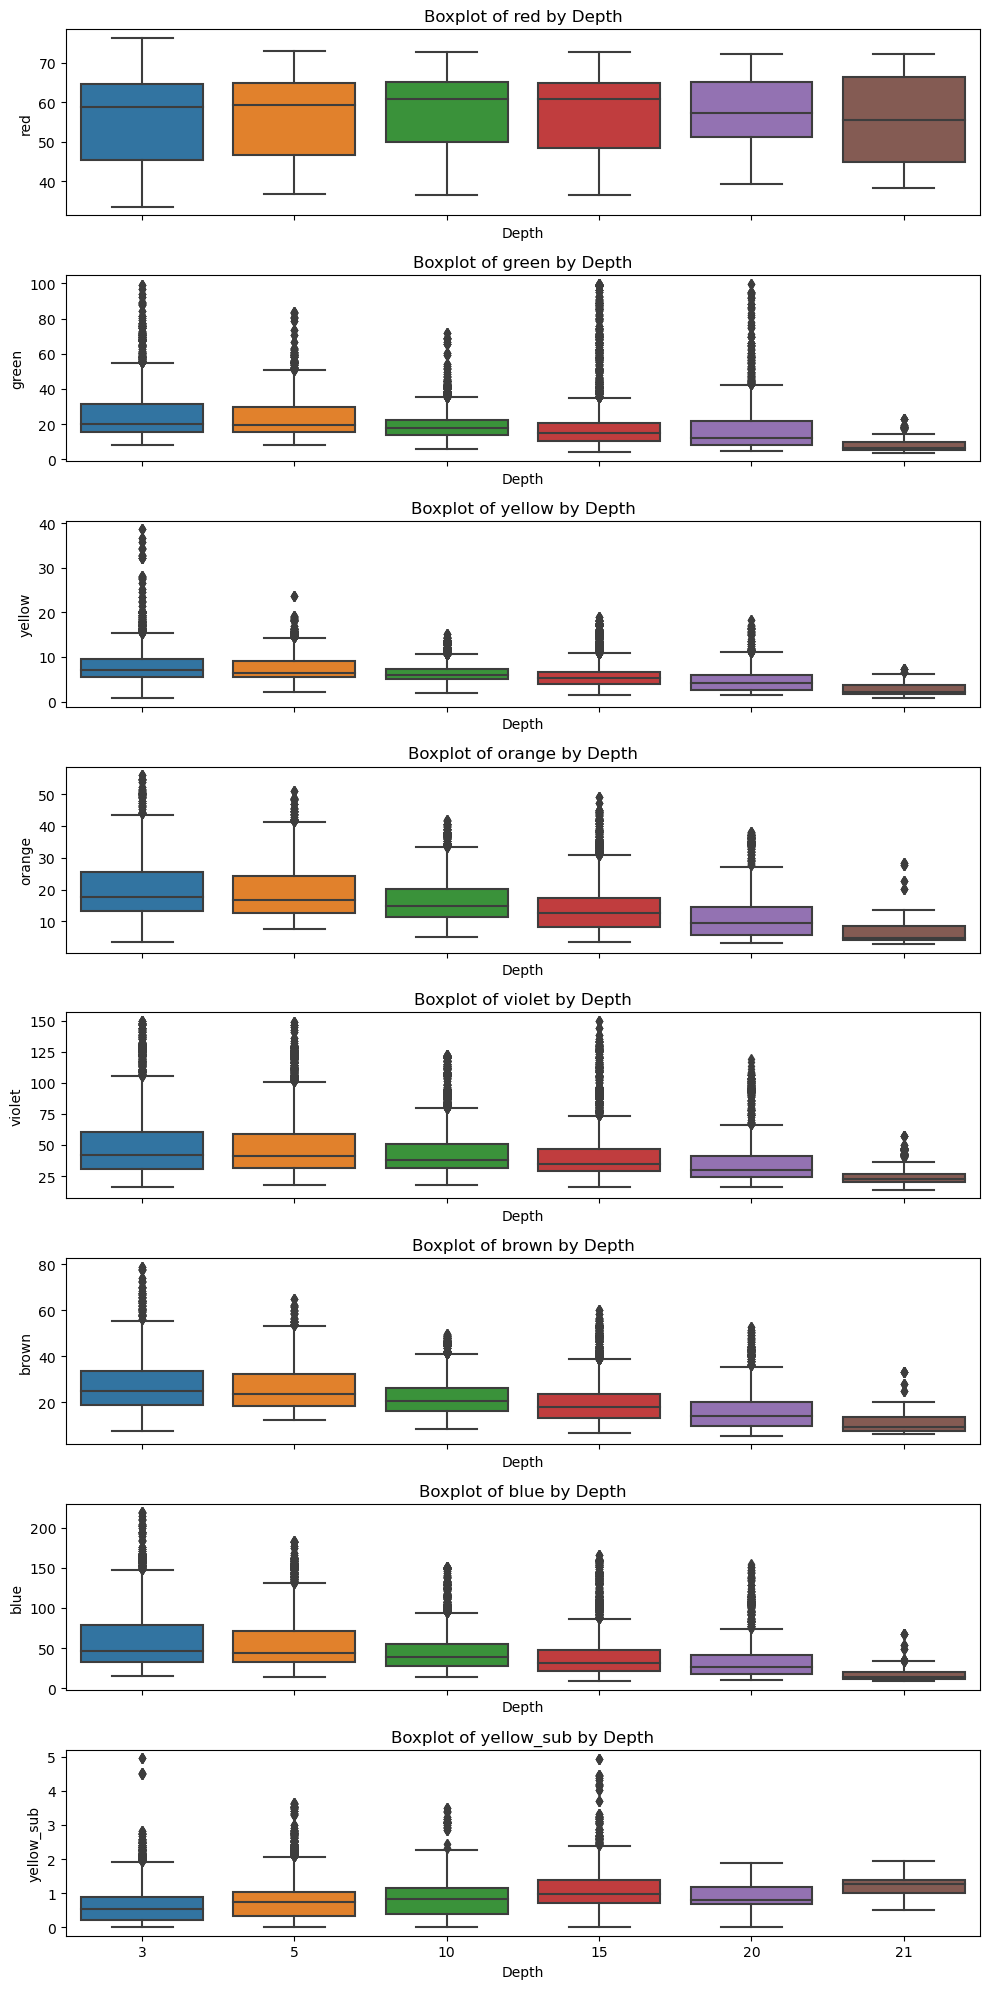

In [63]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

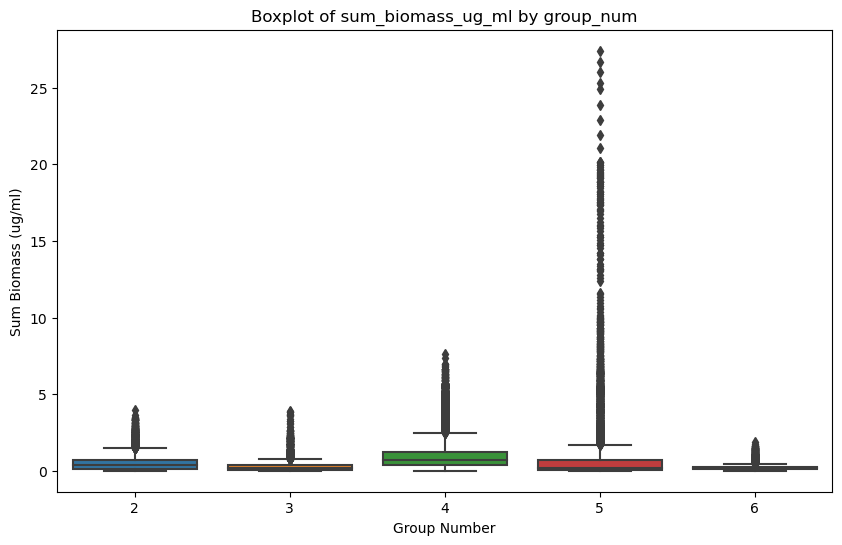

In [64]:
boxplot_biomass_by_group(merged_train)

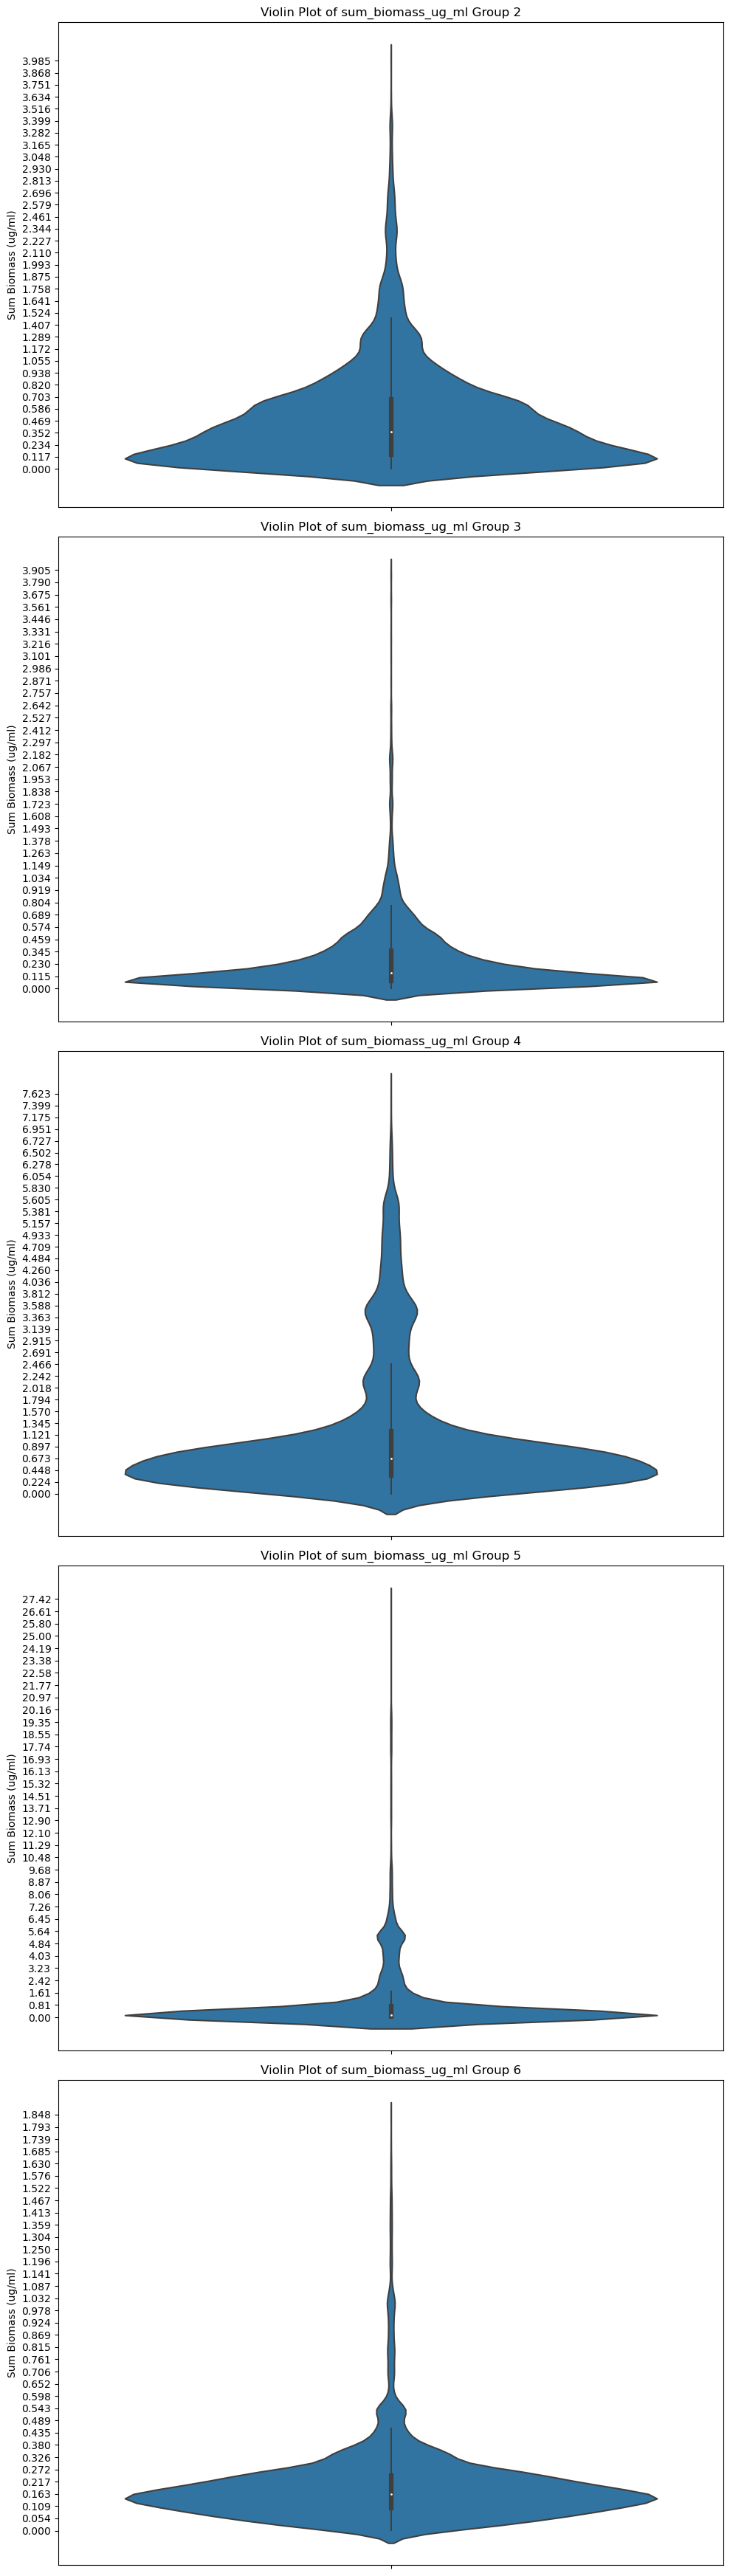

In [65]:
violin_biomass_by_group(merged_train)

In [66]:
boundaries = {
    2: (0.1, 2.5),
    3: (0, 2),
    4: (0, 5),
    5: (0, 3),
    6: (0.02, 1)
}

filter_biomass_by_group_boundaries(merged_train, boundaries)

In [67]:
merged_train.shape

(32077, 18)

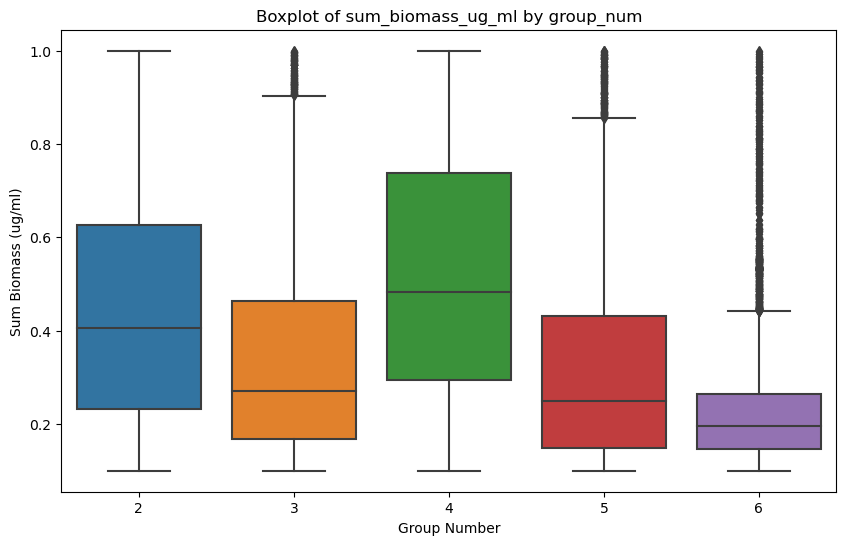

In [68]:
boxplot_biomass_by_group(merged_train)

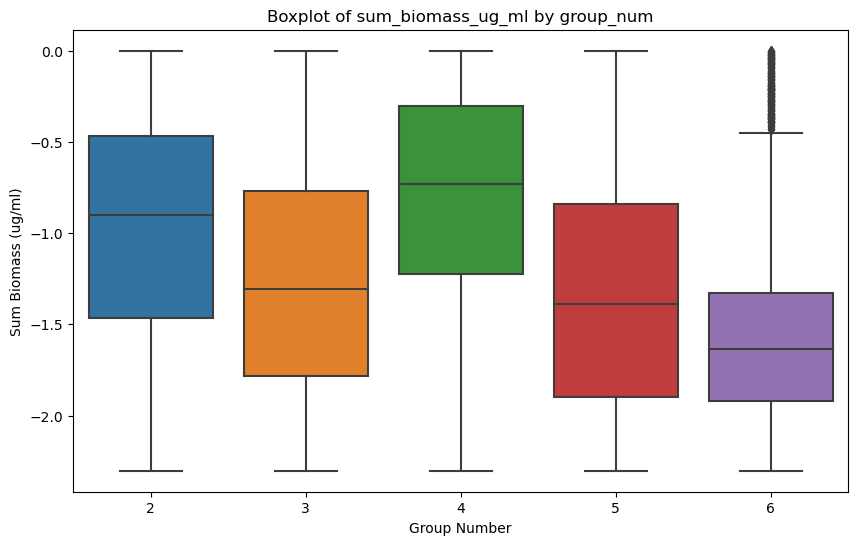

In [69]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.log)
boxplot_biomass_by_group(merged_train)

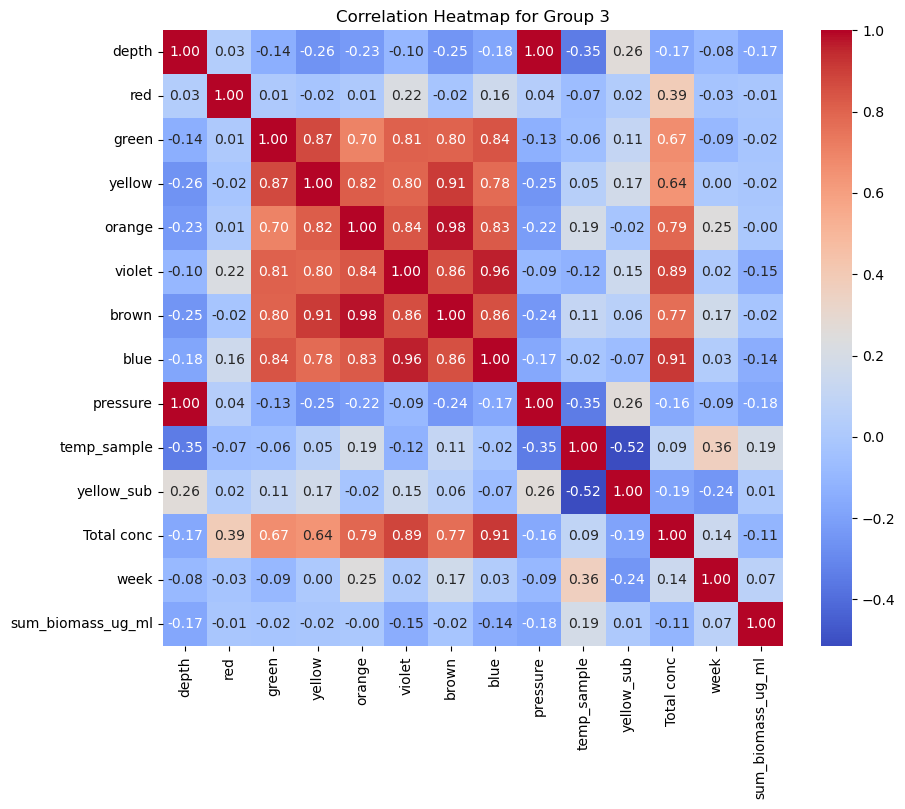

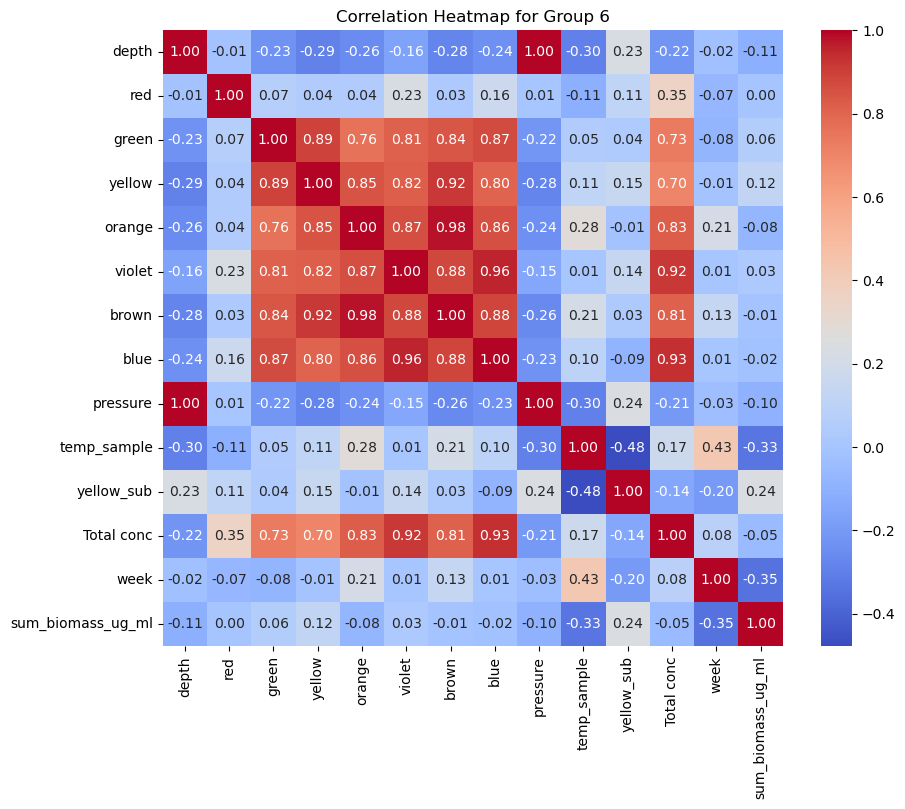

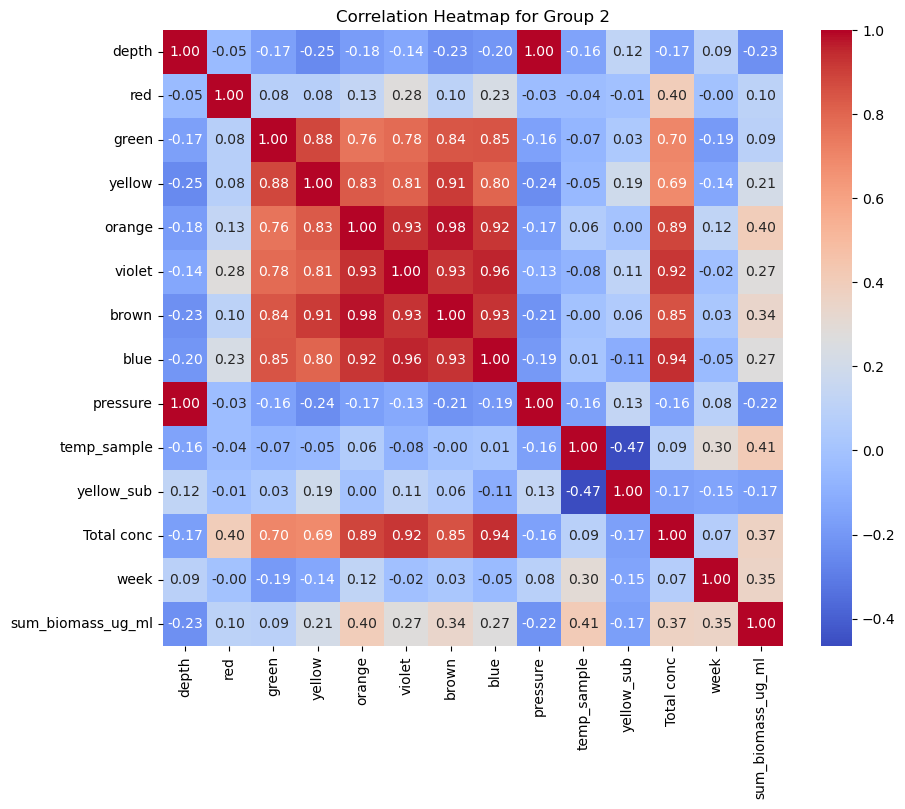

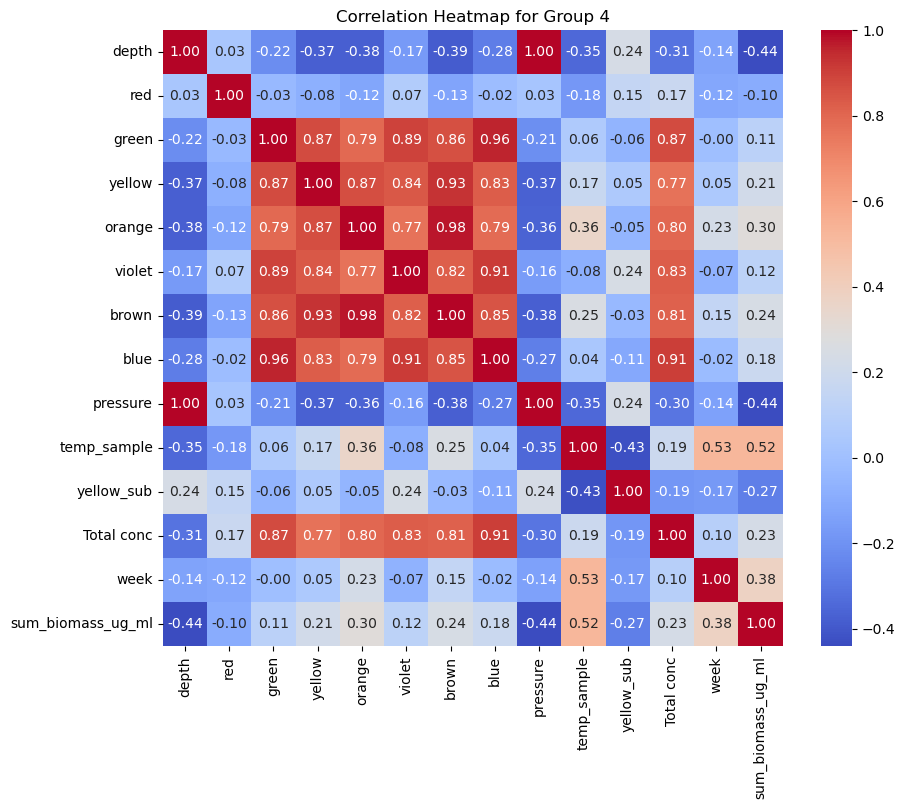

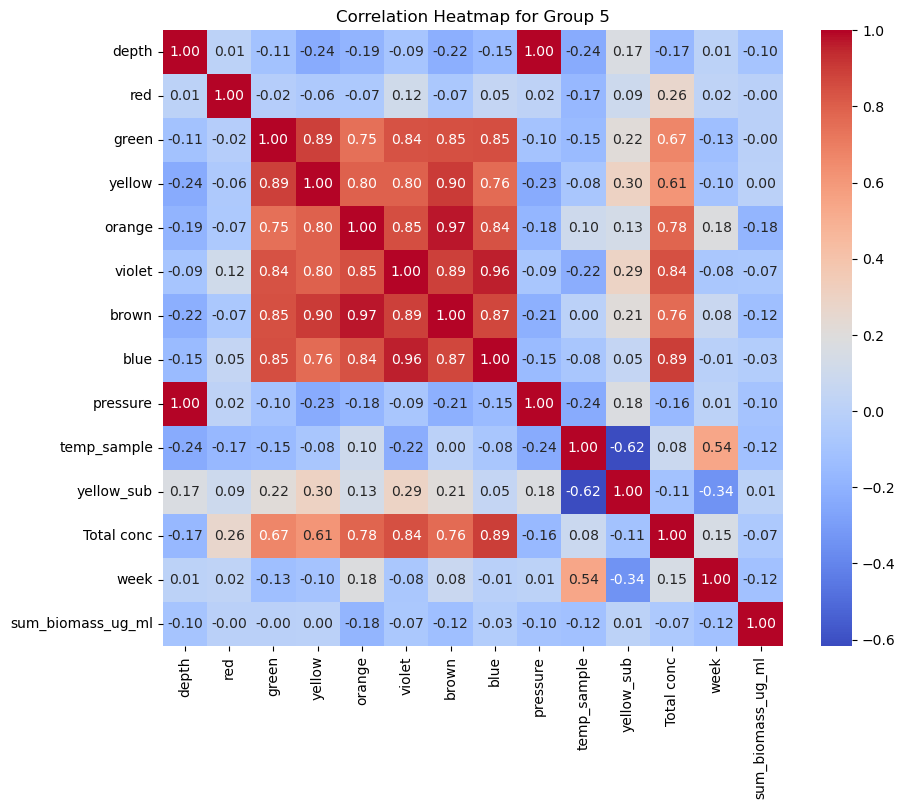

In [70]:
correlation_per_group(merged_train)

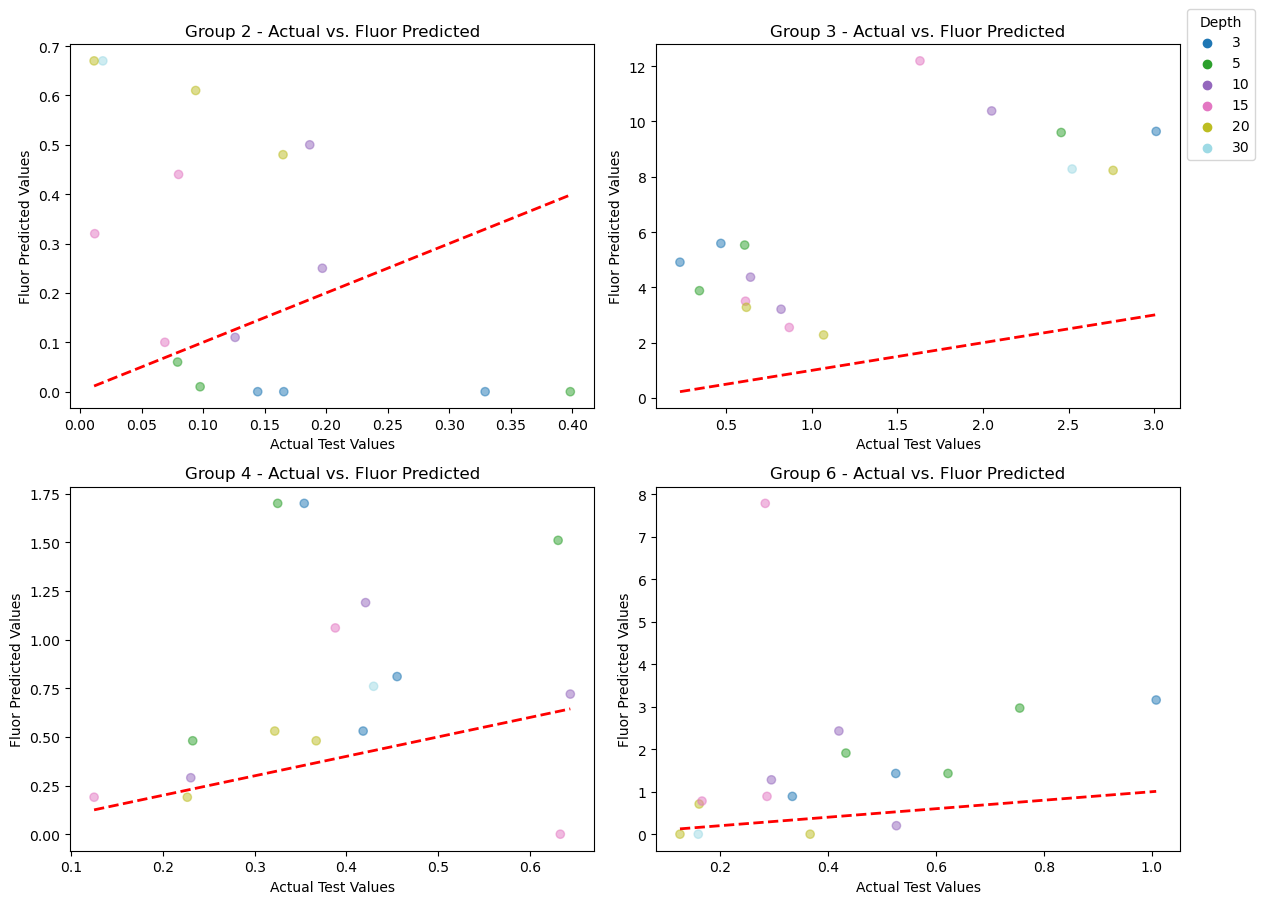

In [71]:
plot_fluorprobe_prediction(fluor_val_df, fluor_groups_map)

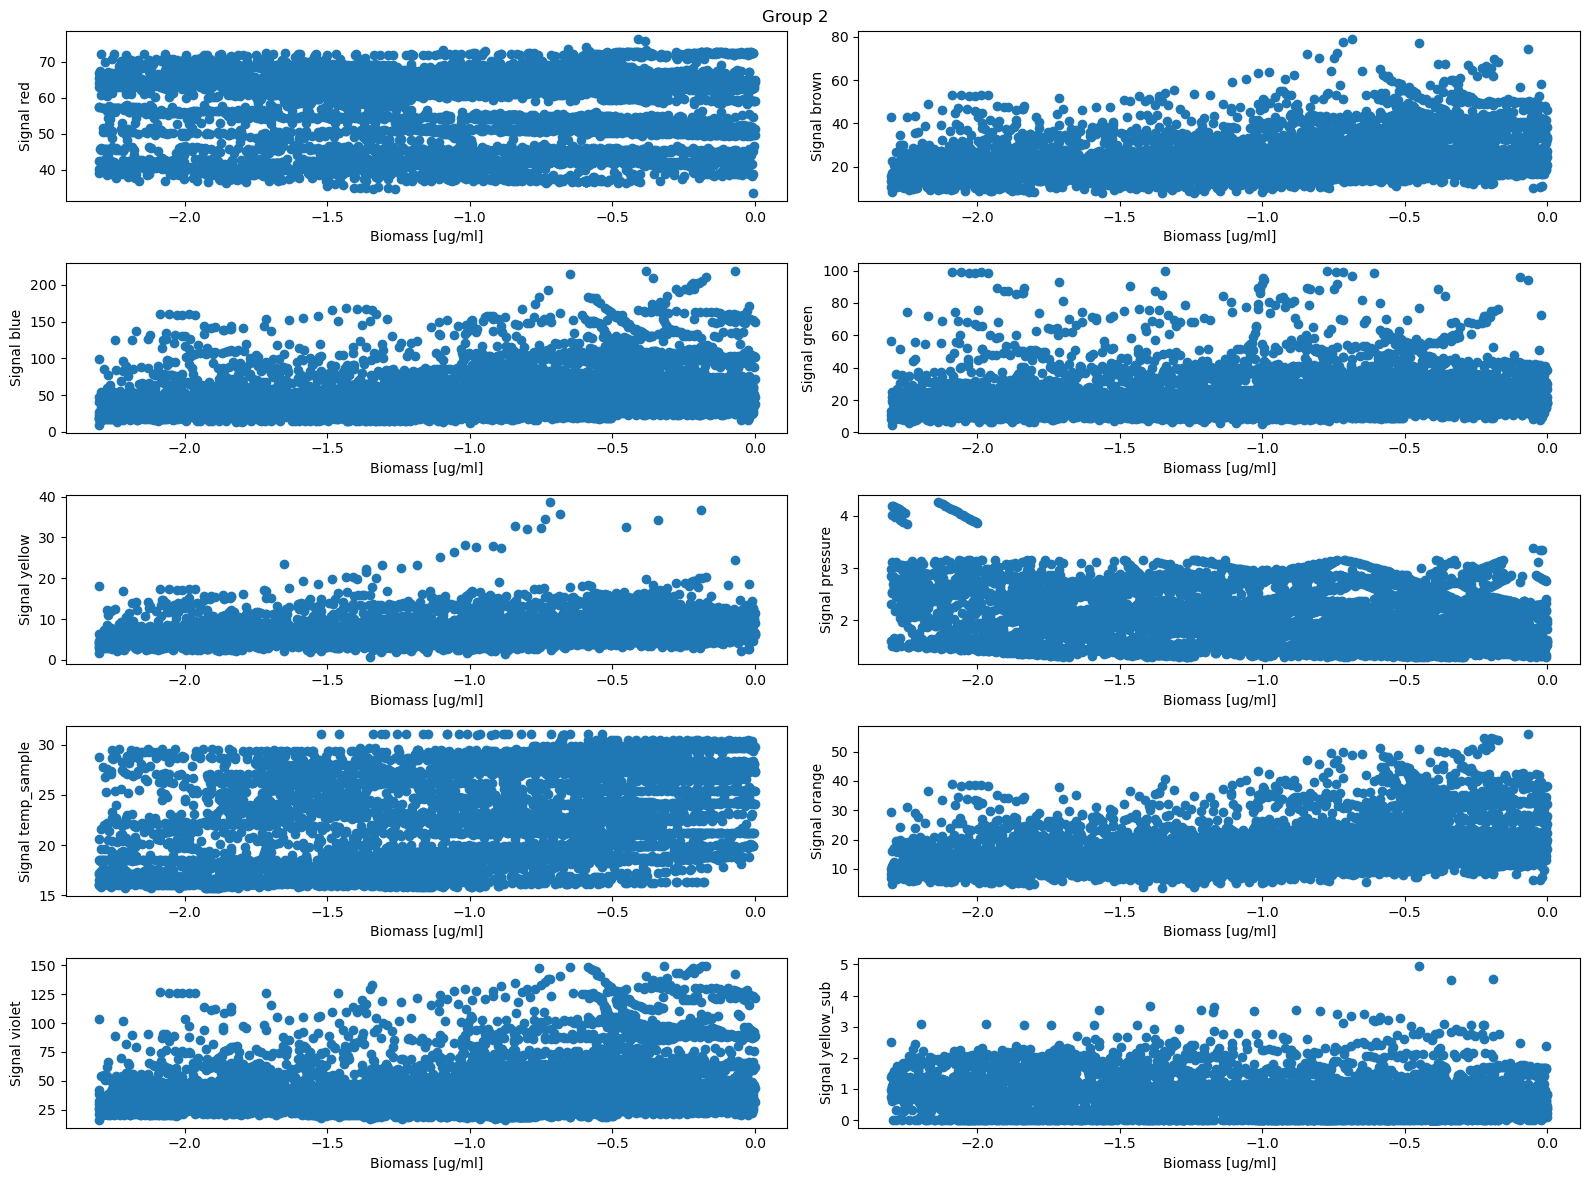

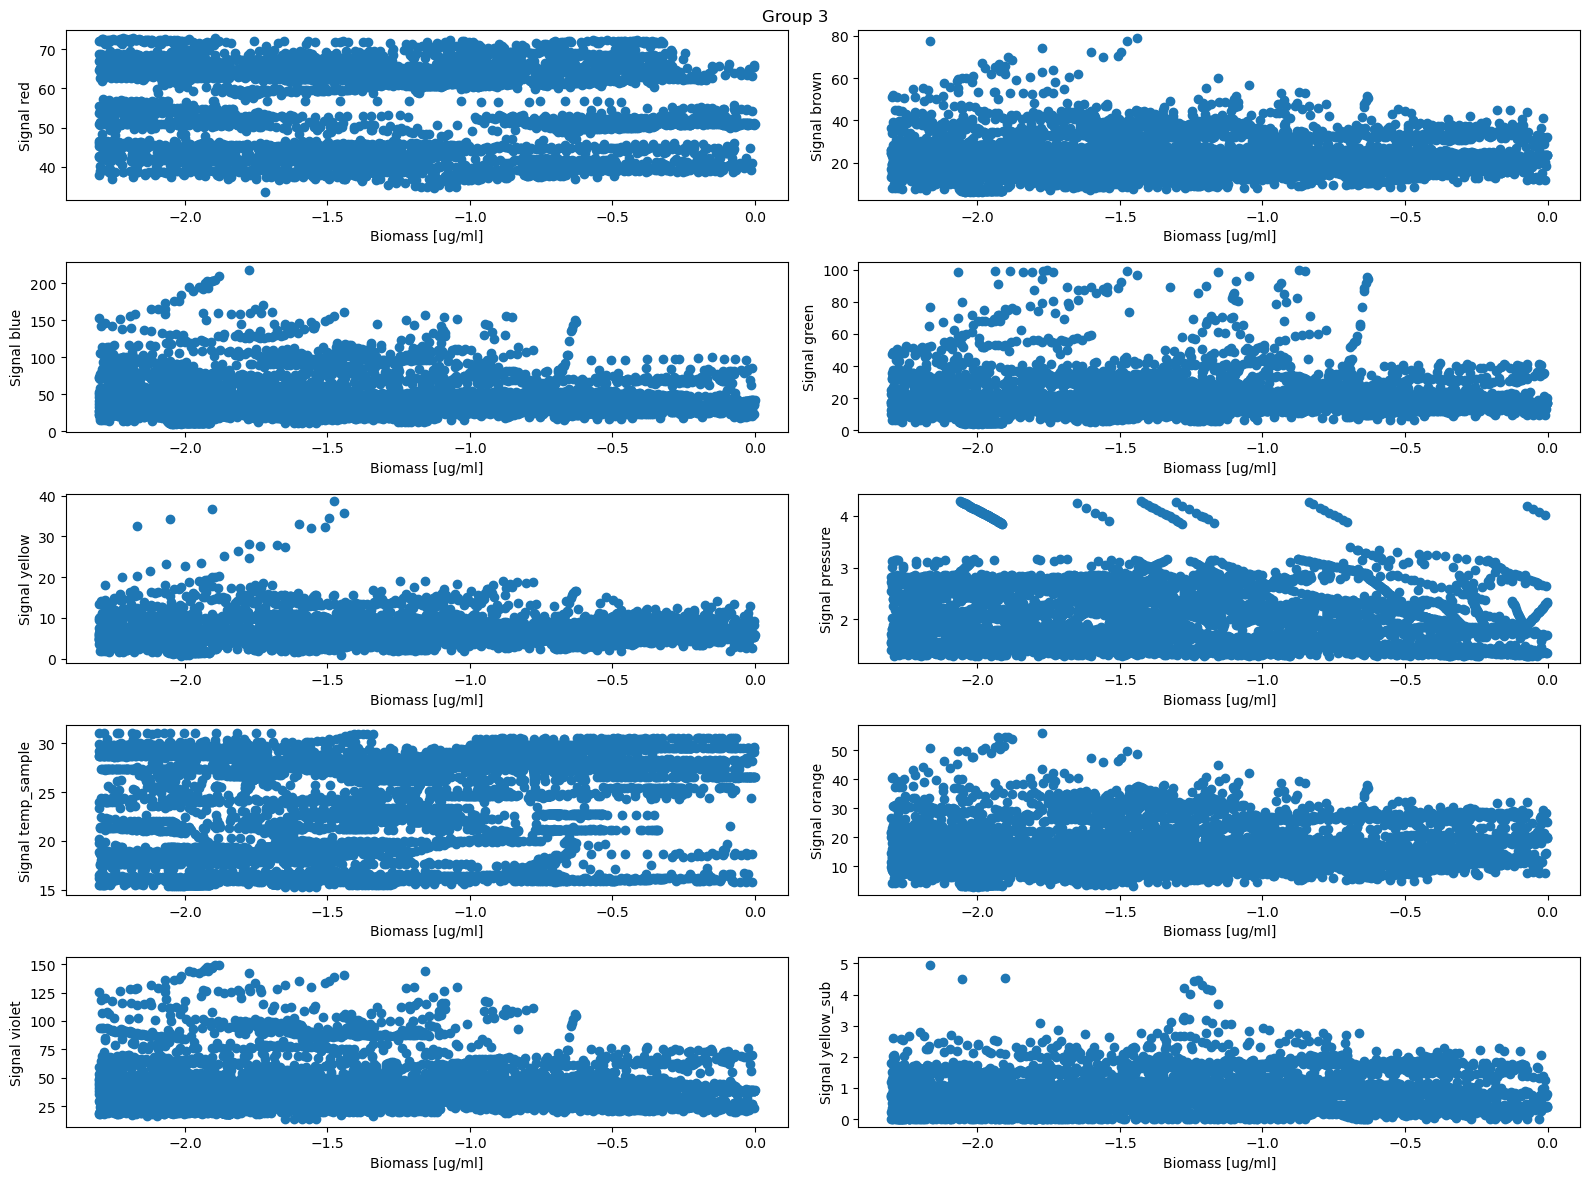

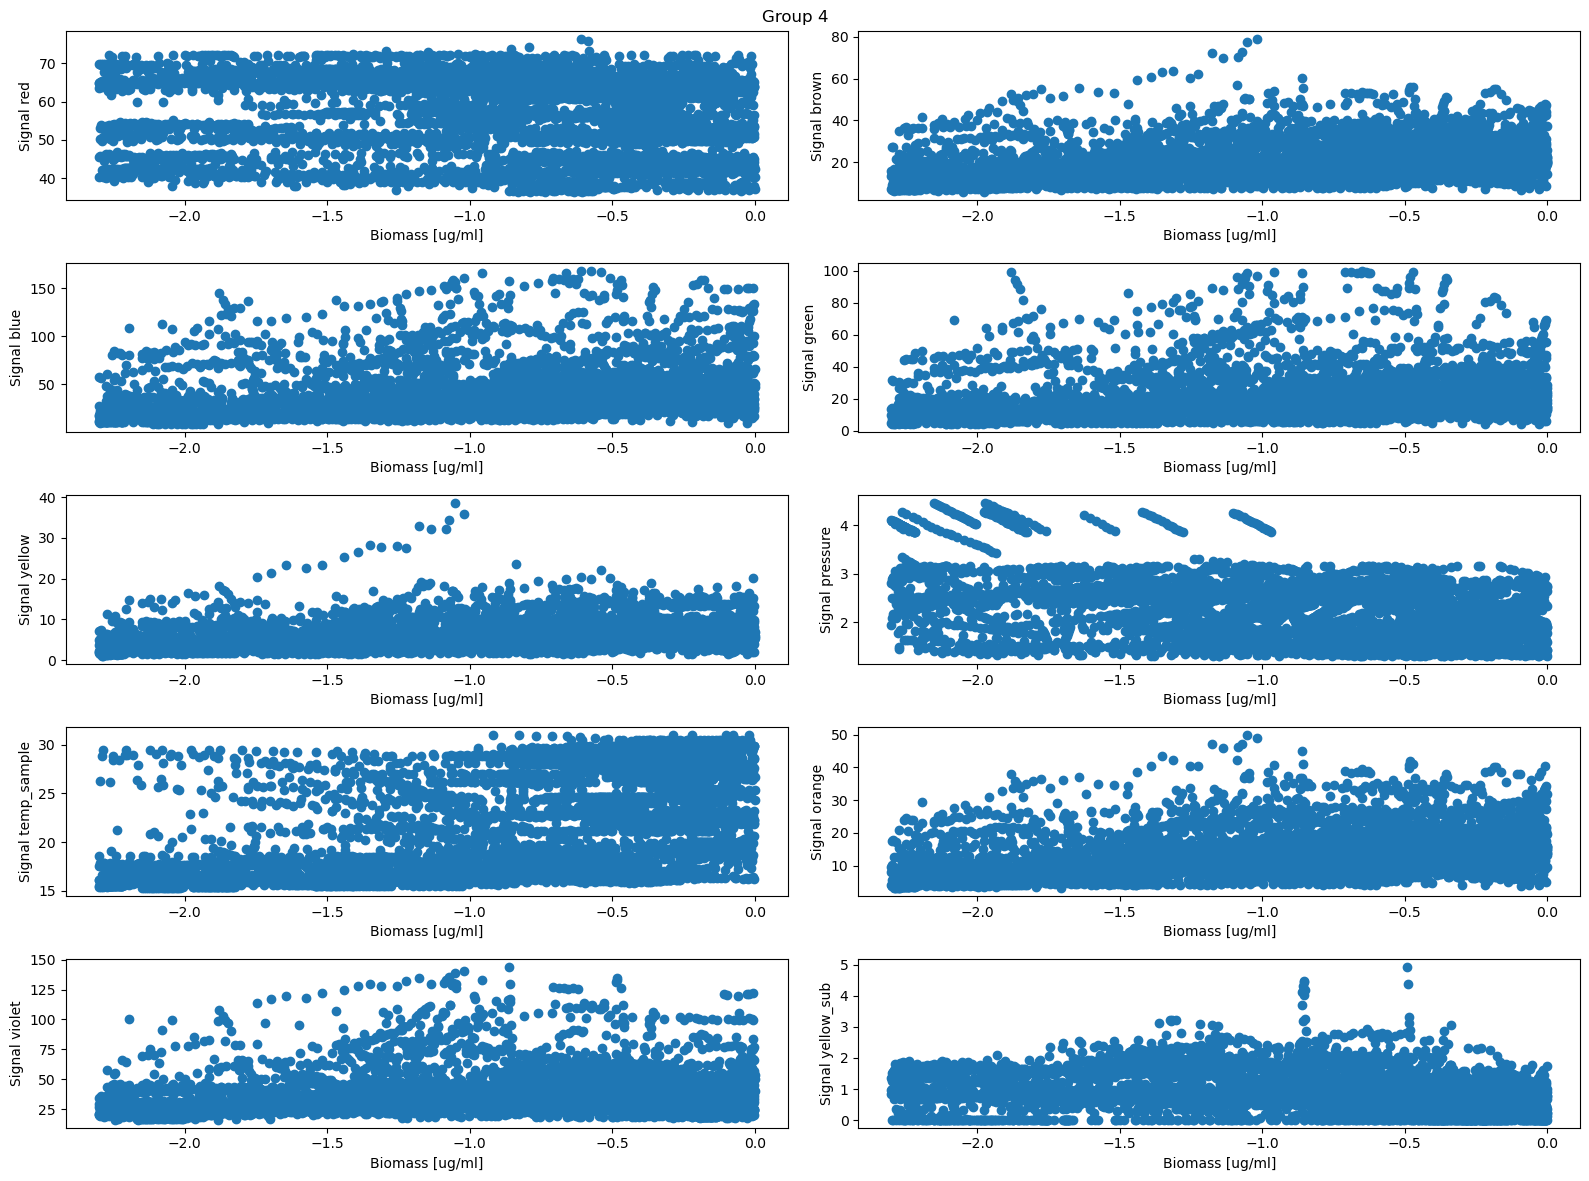

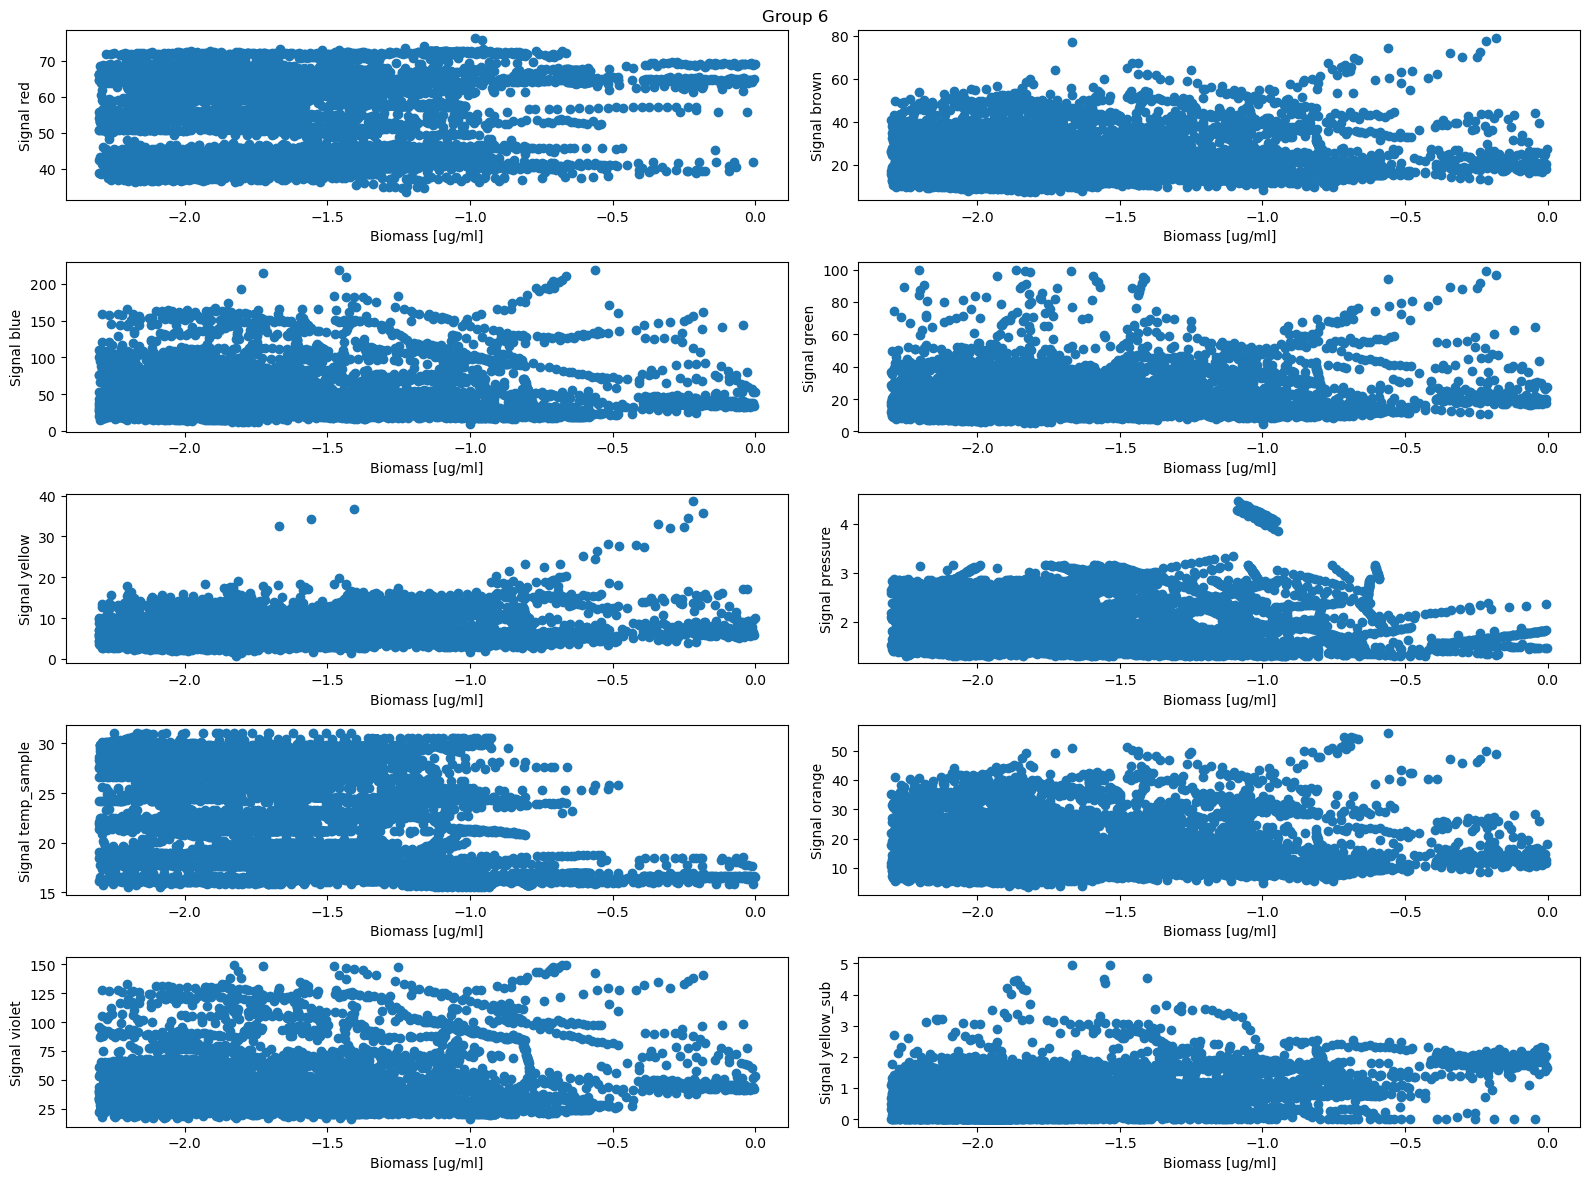

In [72]:
plot_corr_per_feature_per_group(merged_train, fluor_groups_map)

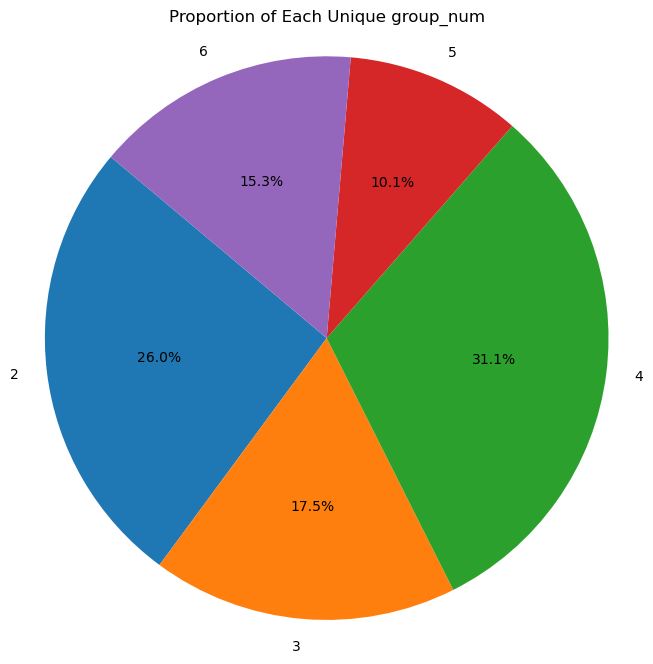

In [73]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.exp)
groups_pie_chart(merged_train, by_biomass=True)

In [74]:
merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
merged_test = merged_test.drop(['year', 'Depth', 'week', 'depth_discrete', 'month'], axis=1)
merged_val = merged_val.drop(['year', 'Depth', 'week', 'depth_discrete', 'month'], axis=1)

# Training models and evaluating

In [81]:
pickled_params = 'best_grid_params.pkl'
do_search = not os.path.exists(pickled_params)

def two_scorer(mse=False):
    score = mean_squared_error if mse else r2_score
    return make_scorer(score, greater_is_better=mse==False)

In [82]:
if do_search:
#     param_grid_per_model = {'xgb': {
#         "model__n_estimators": [100, 300, 500], # Number of boosting rounds
#         "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
#         "model__max_depth": [3, 5, 7, 11], # Maximum depth of a tree,
#         'model__min_child_weight': [1, 5, 7],  # Minimum sum of instance weight needed in a child
#         "model__subsample": [0.2, 0.5, 1.0], # Fraction of samples used for fitting trees
#         "model__colsample_bytree": [0.2, 0.8, 1.0] # Fraction of features used for fitting trees
#     },
#     'svr':  {
#         "model__C": [0.1, 1, 10, 100], # Regularization parameter
#         "model__kernel": ["poly", "rbf"],
#         "model__degree": [1, 2, 3], # Degree of the polynomial kernel (for "poly" kernel)
#         "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
#         "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
#     },
#     'elf': {
#         "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
#         "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
#         "model__fit_intercept": [True, False], # Whether to calculate the intercept for the model
#     }}
    param_grid_per_model = {'xgb': {
        "model__n_estimators": [100, 300, 500], # Number of boosting rounds
        "model__max_depth": [2, 3, 5], # Maximum depth of a tree,
#         "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
        "model__alpha": [0.01, 0.1, 1, 10], # L1 regularization term
        "model__lambda": [0, 0.2, 0.8], # Mixing parameter between L1 and L2 regularization
    },
    'svr':  {
        "model__C": [0.001, 0.1, 1, 10, 100], # Regularization parameter
#         "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
        "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
    },
    'elf': {
        "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    }}
    
    best_group_params_per_model = {}
    for model_name, param_grid in param_grid_per_model.items():
        best_group_params_per_model[model_name] = grid_search_cv(model_name, merged_train, param_grid=param_grid,
                                                                scoring_method=two_scorer(mse=False))
    
    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model, f)
    
    best_group_params_per_model_fixed = {}
    for model_name, kwargs_per_group in best_group_params_per_model.items():
        best_group_params_per_model_fixed[model_name] = {}
        for group_num in kwargs_per_group.keys():
            best_group_params_per_model_fixed[model_name][group_num] = {}
            kwargs = kwargs_per_group[group_num]
            for param, val in kwargs.items():
                fixed_param = param.split('model__')[1]
                best_group_params_per_model_fixed[model_name][group_num][fixed_param] = val


    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model_fixed, f)

else:
    with open(pickled_params, 'rb') as f:
        best_group_params_per_model_fixed = pickle.load(f)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 3/5; 1/108] START model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=100
[CV 3/5; 1/108] END model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=100;, score=0.692 total time=   0.3s
[CV 3/5; 2/108] START model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=300
[CV 3/5; 2/108] END model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=300;, score=0.782 total time=   1.0s
[CV 2/5; 3/108] START model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=500
[CV 2/5; 3/108] END model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=500;, score=0.810 total time=   1.6s
[CV 1/5; 4/108] START model__alpha=0.01, model__lambda=0, model__max_depth=3, model__n_estimators=100
[CV 1/5; 4/108] END model__alpha=0.01, model__lambda=0, model__max_depth=3, model__n_estimators=100;, score=0.824 total time=   0.

[CV 4/5; 1/108] START model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=100
[CV 4/5; 1/108] END model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=100;, score=0.677 total time=   0.3s
[CV 1/5; 2/108] START model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=300
[CV 1/5; 2/108] END model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=300;, score=0.788 total time=   1.0s
[CV 5/5; 2/108] START model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=300
[CV 5/5; 2/108] END model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=300;, score=0.754 total time=   1.0s
[CV 4/5; 3/108] START model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=500
[CV 4/5; 3/108] END model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=500;, score=0.804 total time=   1.6s
[CV 5/5; 4/108] START model__alpha=0.01, model__lambda=0, mo

[CV 5/5; 23/108] START model__alpha=0.01, model__lambda=0.8, model__max_depth=3, model__n_estimators=300
[CV 5/5; 23/108] END model__alpha=0.01, model__lambda=0.8, model__max_depth=3, model__n_estimators=300;, score=0.830 total time=   1.6s
[CV 4/5; 24/108] START model__alpha=0.01, model__lambda=0.8, model__max_depth=3, model__n_estimators=500
[CV 4/5; 24/108] END model__alpha=0.01, model__lambda=0.8, model__max_depth=3, model__n_estimators=500;, score=0.886 total time=   2.7s
[CV 5/5; 25/108] START model__alpha=0.01, model__lambda=0.8, model__max_depth=5, model__n_estimators=100
[CV 5/5; 25/108] END model__alpha=0.01, model__lambda=0.8, model__max_depth=5, model__n_estimators=100;, score=0.856 total time=   0.9s
[CV 3/5; 26/108] START model__alpha=0.01, model__lambda=0.8, model__max_depth=5, model__n_estimators=300
[CV 3/5; 26/108] END model__alpha=0.01, model__lambda=0.8, model__max_depth=5, model__n_estimators=300;, score=0.912 total time=   2.8s
[CV 2/5; 27/108] START model__alpha=

[CV 1/5; 32/108] END model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.873 total time=   1.7s
[CV 5/5; 32/108] START model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=300
[CV 5/5; 32/108] END model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.832 total time=   1.6s
[CV 4/5; 33/108] START model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=500
[CV 4/5; 33/108] END model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=500;, score=0.881 total time=   2.7s
[CV 5/5; 34/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 5/5; 34/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.858 total time=   1.0s
[CV 3/5; 35/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 3/5; 35/108] END model__alpha=0.1, model__lambda=0, mode

[CV 5/5; 52/108] END model__alpha=0.1, model__lambda=0.8, model__max_depth=5, model__n_estimators=100;, score=0.870 total time=   0.9s
[CV 3/5; 53/108] START model__alpha=0.1, model__lambda=0.8, model__max_depth=5, model__n_estimators=300
[CV 3/5; 53/108] END model__alpha=0.1, model__lambda=0.8, model__max_depth=5, model__n_estimators=300;, score=0.907 total time=   2.9s
[CV 2/5; 54/108] START model__alpha=0.1, model__lambda=0.8, model__max_depth=5, model__n_estimators=500
[CV 2/5; 54/108] END model__alpha=0.1, model__lambda=0.8, model__max_depth=5, model__n_estimators=500;, score=0.916 total time=   3.4s
[CV 1/5; 55/108] START model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=100
[CV 1/5; 55/108] END model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=100;, score=0.691 total time=   0.4s
[CV 2/5; 55/108] START model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=100
[CV 2/5; 55/108] END model__alpha=1, model__lambda=0, mo

[CV 5/5; 56/108] START model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=300
[CV 5/5; 56/108] END model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=300;, score=0.738 total time=   1.1s
[CV 4/5; 57/108] START model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=500
[CV 4/5; 57/108] END model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=500;, score=0.788 total time=   1.8s
[CV 3/5; 58/108] START model__alpha=1, model__lambda=0, model__max_depth=3, model__n_estimators=100
[CV 3/5; 58/108] END model__alpha=1, model__lambda=0, model__max_depth=3, model__n_estimators=100;, score=0.802 total time=   0.6s
[CV 1/5; 59/108] START model__alpha=1, model__lambda=0, model__max_depth=3, model__n_estimators=300
[CV 1/5; 59/108] END model__alpha=1, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.864 total time=   1.6s
[CV 5/5; 59/108] START model__alpha=1, model__lambda=0, model__max_depth=3, 

[CV 5/5; 77/108] END model__alpha=1, model__lambda=0.8, model__max_depth=3, model__n_estimators=300;, score=0.823 total time=   1.5s
[CV 4/5; 78/108] START model__alpha=1, model__lambda=0.8, model__max_depth=3, model__n_estimators=500
[CV 4/5; 78/108] END model__alpha=1, model__lambda=0.8, model__max_depth=3, model__n_estimators=500;, score=0.858 total time=   2.0s
[CV 4/5; 79/108] START model__alpha=1, model__lambda=0.8, model__max_depth=5, model__n_estimators=100
[CV 4/5; 79/108] END model__alpha=1, model__lambda=0.8, model__max_depth=5, model__n_estimators=100;, score=0.898 total time=   0.9s
[CV 3/5; 80/108] START model__alpha=1, model__lambda=0.8, model__max_depth=5, model__n_estimators=300
[CV 3/5; 80/108] END model__alpha=1, model__lambda=0.8, model__max_depth=5, model__n_estimators=300;, score=0.881 total time=   1.2s
[CV 2/5; 81/108] START model__alpha=1, model__lambda=0.8, model__max_depth=5, model__n_estimators=500
[CV 2/5; 81/108] END model__alpha=1, model__lambda=0.8, mode

[CV 1/5; 85/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=100;, score=0.635 total time=   0.3s
[CV 3/5; 85/108] START model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=100
[CV 3/5; 85/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=100;, score=0.629 total time=   0.4s
[CV 1/5; 86/108] START model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=300
[CV 1/5; 86/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.635 total time=   0.7s
[CV 5/5; 86/108] START model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=300
[CV 5/5; 86/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.590 total time=   0.7s
[CV 4/5; 87/108] START model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=500
[CV 4/5; 87/108] END model__alpha=10, model__lambda=0, model__max_de

[CV 4/5; 86/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.588 total time=   0.7s
[CV 2/5; 87/108] START model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=500
[CV 2/5; 87/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=500;, score=0.628 total time=   1.1s
[CV 1/5; 88/108] START model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 1/5; 88/108] END model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.689 total time=   0.4s
[CV 3/5; 88/108] START model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 3/5; 88/108] END model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.684 total time=   0.4s
[CV 1/5; 89/108] START model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 1/5; 89/108] END model__alpha=10, model__lambda=0, model__max_de

[CV 3/5; 3/108] START model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=500
[CV 3/5; 3/108] END model__alpha=0.01, model__lambda=0, model__max_depth=2, model__n_estimators=500;, score=0.727 total time=   2.2s
[CV 2/5; 4/108] START model__alpha=0.01, model__lambda=0, model__max_depth=3, model__n_estimators=100
[CV 2/5; 4/108] END model__alpha=0.01, model__lambda=0, model__max_depth=3, model__n_estimators=100;, score=0.784 total time=   0.7s
[CV 4/5; 4/108] START model__alpha=0.01, model__lambda=0, model__max_depth=3, model__n_estimators=100
[CV 4/5; 4/108] END model__alpha=0.01, model__lambda=0, model__max_depth=3, model__n_estimators=100;, score=0.766 total time=   0.7s
[CV 2/5; 5/108] START model__alpha=0.01, model__lambda=0, model__max_depth=3, model__n_estimators=300
[CV 2/5; 5/108] END model__alpha=0.01, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.826 total time=   1.9s
[CV 1/5; 6/108] START model__alpha=0.01, model__lambda=0, mo

[CV 4/5; 5/108] END model__alpha=0.01, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.797 total time=   1.9s
[CV 3/5; 6/108] START model__alpha=0.01, model__lambda=0, model__max_depth=3, model__n_estimators=500
[CV 3/5; 6/108] END model__alpha=0.01, model__lambda=0, model__max_depth=3, model__n_estimators=500;, score=0.820 total time=   3.2s
[CV 2/5; 7/108] START model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 2/5; 7/108] END model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.864 total time=   1.1s
[CV 5/5; 7/108] START model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 5/5; 7/108] END model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.865 total time=   1.1s
[CV 3/5; 8/108] START model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 3/5; 8/108] END model__alpha=0.01, model__lambda=0, mode

[CV 5/5; 28/108] START model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=100
[CV 5/5; 28/108] END model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=100;, score=0.684 total time=   0.4s
[CV 2/5; 29/108] START model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=300
[CV 2/5; 29/108] END model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=300;, score=0.775 total time=   1.3s
[CV 4/5; 29/108] START model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=300
[CV 4/5; 29/108] END model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=300;, score=0.748 total time=   1.3s
[CV 2/5; 30/108] START model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=500
[CV 2/5; 30/108] END model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=500;, score=0.799 total time=   2.1s
[CV 1/5; 31/108] START model__alpha=0.1, model__lambda=0, mo

[CV 4/5; 35/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=300;, score=0.869 total time=   3.2s
[CV 3/5; 36/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=500
[CV 3/5; 36/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=500;, score=0.874 total time=   3.6s
[CV 5/5; 36/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=500
[CV 5/5; 36/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=500;, score=0.891 total time=   3.6s
[CV 1/5; 39/108] START model__alpha=0.1, model__lambda=0.2, model__max_depth=2, model__n_estimators=500
[CV 1/5; 39/108] END model__alpha=0.1, model__lambda=0.2, model__max_depth=2, model__n_estimators=500;, score=0.783 total time=   2.2s
[CV 5/5; 39/108] START model__alpha=0.1, model__lambda=0.2, model__max_depth=2, model__n_estimators=500
[CV 5/5; 39/108] END model__alpha=0.1, model__lambda=0

[CV 4/5; 77/108] END model__alpha=1, model__lambda=0.8, model__max_depth=3, model__n_estimators=300;, score=0.800 total time=   1.6s[CV 1/5; 54/108] END model__alpha=0.1, model__lambda=0.8, model__max_depth=5, model__n_estimators=500;, score=0.900 total time=   3.9s
[CV 5/5; 54/108] START model__alpha=0.1, model__lambda=0.8, model__max_depth=5, model__n_estimators=500
[CV 5/5; 54/108] END model__alpha=0.1, model__lambda=0.8, model__max_depth=5, model__n_estimators=500;, score=0.890 total time=   3.8s
[CV 1/5; 57/108] START model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=500
[CV 1/5; 57/108] END model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=500;, score=0.779 total time=   2.1s
[CV 5/5; 57/108] START model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=500
[CV 5/5; 57/108] END model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=500;, score=0.775 total time=   2.2s
[CV 4/5; 59/108] START model__al

[CV 3/5; 65/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 3/5; 65/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.723 total time=   1.3s
[CV 2/5; 66/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=500
[CV 2/5; 66/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=500;, score=0.784 total time=   2.1s
[CV 1/5; 67/108] START model__alpha=1, model__lambda=0.2, model__max_depth=3, model__n_estimators=100
[CV 1/5; 67/108] END model__alpha=1, model__lambda=0.2, model__max_depth=3, model__n_estimators=100;, score=0.785 total time=   0.7s
[CV 3/5; 67/108] START model__alpha=1, model__lambda=0.2, model__max_depth=3, model__n_estimators=100
[CV 3/5; 67/108] END model__alpha=1, model__lambda=0.2, model__max_depth=3, model__n_estimators=100;, score=0.760 total time=   0.7s
[CV 1/5; 68/108] START model__alpha=1, model__lambda=0.2, mo


[CV 3/5; 78/108] START model__alpha=1, model__lambda=0.8, model__max_depth=3, model__n_estimators=500
[CV 3/5; 78/108] END model__alpha=1, model__lambda=0.8, model__max_depth=3, model__n_estimators=500;, score=0.802 total time=   2.1s
[CV 2/5; 79/108] START model__alpha=1, model__lambda=0.8, model__max_depth=5, model__n_estimators=100
[CV 2/5; 79/108] END model__alpha=1, model__lambda=0.8, model__max_depth=5, model__n_estimators=100;, score=0.862 total time=   1.1s
[CV 5/5; 79/108] START model__alpha=1, model__lambda=0.8, model__max_depth=5, model__n_estimators=100
[CV 5/5; 79/108] END model__alpha=1, model__lambda=0.8, model__max_depth=5, model__n_estimators=100;, score=0.862 total time=   1.0s
[CV 4/5; 80/108] START model__alpha=1, model__lambda=0.8, model__max_depth=5, model__n_estimators=300
[CV 4/5; 80/108] END model__alpha=1, model__lambda=0.8, model__max_depth=5, model__n_estimators=300;, score=0.853 total time=   1.6s
[CV 3/5; 81/108] START model__alpha=1, model__lambda=0.8, m

[CV 1/5; 91/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.546 total time=   0.3s
[CV 3/5; 91/108] START model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 3/5; 91/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.498 total time=   0.3s
[CV 1/5; 92/108] START model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 1/5; 92/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.546 total time=   0.7s
[CV 5/5; 92/108] START model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 5/5; 92/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.483 total time=   0.7s
[CV 4/5; 93/108] START model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=500
[CV 4/5; 93/108] END model__alpha=10, model__lambda=

[CV 4/5; 104/108] END model__alpha=10, model__lambda=0.8, model__max_depth=3, model__n_estimators=300;, score=0.571 total time=   0.8s
[CV 3/5; 105/108] START model__alpha=10, model__lambda=0.8, model__max_depth=3, model__n_estimators=500
[CV 3/5; 105/108] END model__alpha=10, model__lambda=0.8, model__max_depth=3, model__n_estimators=500;, score=0.552 total time=   1.3s
[CV 2/5; 106/108] START model__alpha=10, model__lambda=0.8, model__max_depth=5, model__n_estimators=100
[CV 2/5; 106/108] END model__alpha=10, model__lambda=0.8, model__max_depth=5, model__n_estimators=100;, score=0.653 total time=   0.5s
[CV 5/5; 106/108] START model__alpha=10, model__lambda=0.8, model__max_depth=5, model__n_estimators=100
[CV 5/5; 106/108] END model__alpha=10, model__lambda=0.8, model__max_depth=5, model__n_estimators=100;, score=0.629 total time=   0.5s
[CV 4/5; 107/108] START model__alpha=10, model__lambda=0.8, model__max_depth=5, model__n_estimators=300
[CV 4/5; 107/108] END model__alpha=10, model

[CV 2/5; 10/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 2/5; 10/108] END model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.725 total time=   0.4s
[CV 4/5; 10/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 4/5; 10/108] END model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.707 total time=   0.4s
[CV 1/5; 11/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 1/5; 11/108] END model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.782 total time=   1.2s
[CV 4/5; 11/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 4/5; 11/108] END model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.776 total time=   1.2s
[CV 2/5; 12/108] START model__alpha=

[CV 4/5; 28/108] END model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=100;, score=0.705 total time=   0.4s
[CV 1/5; 29/108] START model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=300
[CV 1/5; 29/108] END model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=300;, score=0.778 total time=   1.2s
[CV 3/5; 29/108] START model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=300
[CV 3/5; 29/108] END model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=300;, score=0.784 total time=   1.2s
[CV 1/5; 30/108] START model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=500
[CV 1/5; 30/108] END model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=500;, score=0.801 total time=   2.0s
[CV 5/5; 30/108] START model__alpha=0.1, model__lambda=0, model__max_depth=2, model__n_estimators=500
[CV 5/5; 30/108] END model__alpha=0.1, model__lambda=0, mode

[CV 2/5; 31/108] END model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=100;, score=0.798 total time=   0.6s
[CV 4/5; 31/108] START model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=100
[CV 4/5; 31/108] END model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=100;, score=0.792 total time=   0.6s
[CV 2/5; 32/108] START model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=300
[CV 2/5; 32/108] END model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.841 total time=   1.8s
[CV 1/5; 33/108] START model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=500
[CV 1/5; 33/108] END model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=500;, score=0.867 total time=   3.0s
[CV 5/5; 33/108] START model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=500
[CV 5/5; 33/108] END model__alpha=0.1, model__lambda=0, mode

[CV 5/5; 56/108] END model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=300;, score=0.784 total time=   1.2s
[CV 3/5; 57/108] START model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=500
[CV 3/5; 57/108] END model__alpha=1, model__lambda=0, model__max_depth=2, model__n_estimators=500;, score=0.791 total time=   2.0s
[CV 2/5; 58/108] START model__alpha=1, model__lambda=0, model__max_depth=3, model__n_estimators=100
[CV 2/5; 58/108] END model__alpha=1, model__lambda=0, model__max_depth=3, model__n_estimators=100;, score=0.789 total time=   0.6s
[CV 5/5; 58/108] START model__alpha=1, model__lambda=0, model__max_depth=3, model__n_estimators=100
[CV 5/5; 58/108] END model__alpha=1, model__lambda=0, model__max_depth=3, model__n_estimators=100;, score=0.806 total time=   0.6s
[CV 4/5; 59/108] START model__alpha=1, model__lambda=0, model__max_depth=3, model__n_estimators=300
[CV 4/5; 59/108] END model__alpha=1, model__lambda=0, model__max_depth=3, mo

[CV 1/5; 64/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.699 total time=   0.4s
[CV 3/5; 64/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 3/5; 64/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.701 total time=   0.4s
[CV 5/5; 64/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 5/5; 64/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.718 total time=   0.4s
[CV 3/5; 65/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 3/5; 65/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.770 total time=   1.2s
[CV 2/5; 66/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=500
[CV 2/5; 66/108] END model__alpha=1, model__lambda=0.2, mode

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 83/108] END model__alpha=10, model__lambda=0, model__max_depth=2, model__n_estimators=300;, score=0.609 total time=   0.8s
[CV 4/5; 83/108] START model__alpha=10, model__lambda=0, model__max_depth=2, model__n_estimators=300
[CV 4/5; 83/108] END model__alpha=10, model__lambda=0, model__max_depth=2, model__n_estimators=300;, score=0.633 total time=   0.8s
[CV 3/5; 84/108] START model__alpha=10, model__lambda=0, model__max_depth=2, model__n_estimators=500
[CV 3/5; 84/108] END model__alpha=10, model__lambda=0, model__max_depth=2, model__n_estimators=500;, score=0.625 total time=   1.2s
[CV 3/5; 85/108] START model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=100
[CV 3/5; 85/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=100;, score=0.657 total time=   0.4s
[CV 1/5; 86/108] START model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=300
[CV 1

[CV 1/5; 87/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=500;, score=0.636 total time=   1.2s
[CV 5/5; 87/108] START model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=500
[CV 5/5; 87/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=500;, score=0.666 total time=   1.2s
[CV 4/5; 89/108] START model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 4/5; 89/108] END model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=300;, score=0.700 total time=   0.8s
[CV 3/5; 90/108] START model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=500
[CV 3/5; 90/108] END model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=500;, score=0.694 total time=   1.2s
[CV 2/5; 91/108] START model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 2/5; 91/108] END model__alpha=10, model__lambda=0.2, model__ma

[CV 1/5; 90/108] START model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=500
[CV 1/5; 90/108] END model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=500;, score=0.686 total time=   1.2s
[CV 5/5; 90/108] START model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=500
[CV 5/5; 90/108] END model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=500;, score=0.702 total time=   1.2s
[CV 4/5; 92/108] START model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 4/5; 92/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.635 total time=   0.8s
[CV 3/5; 93/108] START model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=500
[CV 3/5; 93/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=500;, score=0.621 total time=   1.1s
[CV 2/5; 94/108] START model__alpha=10, model__lambda=0.2, m

[CV 3/5; 7/108] START model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 3/5; 7/108] END model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.915 total time=   1.1s
[CV 1/5; 8/108] START model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 1/5; 8/108] END model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=300;, score=0.908 total time=   3.1s
[CV 5/5; 8/108] START model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 5/5; 8/108] END model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=300;, score=0.908 total time=   3.1s
[CV 4/5; 9/108] START model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=500
[CV 4/5; 9/108] END model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=500;, score=0.921 total time=   5.2s
[CV 5/5; 11/108] START model__alpha=0.01, model__lambda=0.2,

[CV 2/5; 9/108] END model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=500;, score=0.906 total time=   5.2s
[CV 1/5; 10/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 1/5; 10/108] END model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.756 total time=   0.4s
[CV 4/5; 10/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 4/5; 10/108] END model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.786 total time=   0.4s
[CV 1/5; 11/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 1/5; 11/108] END model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.805 total time=   1.2s
[CV 3/5; 11/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 3/5; 11/108] END model__alpha=0.01,

[CV 4/5; 32/108] END model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.892 total time=   1.9s
[CV 3/5; 33/108] START model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=500
[CV 3/5; 33/108] END model__alpha=0.1, model__lambda=0, model__max_depth=3, model__n_estimators=500;, score=0.899 total time=   3.1s
[CV 2/5; 34/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 2/5; 34/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.907 total time=   1.1s
[CV 4/5; 34/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 4/5; 34/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.919 total time=   1.1s
[CV 2/5; 35/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 2/5; 35/108] END model__alpha=0.1, model__lambda=0, mode

[CV 5/5; 35/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=300;, score=0.914 total time=   3.2s
[CV 4/5; 36/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=500
[CV 4/5; 36/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=500;, score=0.930 total time=   4.8s
[CV 5/5; 38/108] START model__alpha=0.1, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 5/5; 38/108] END model__alpha=0.1, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.807 total time=   1.2s
[CV 3/5; 39/108] START model__alpha=0.1, model__lambda=0.2, model__max_depth=2, model__n_estimators=500
[CV 3/5; 39/108] END model__alpha=0.1, model__lambda=0.2, model__max_depth=2, model__n_estimators=500;, score=0.843 total time=   2.0s
[CV 2/5; 40/108] START model__alpha=0.1, model__lambda=0.2, model__max_depth=3, model__n_estimators=100
[CV 2/5; 40/108] END model__alpha=0.1, model__lamb

[CV 1/5; 63/108] START model__alpha=1, model__lambda=0, model__max_depth=5, model__n_estimators=500
[CV 1/5; 63/108] END model__alpha=1, model__lambda=0, model__max_depth=5, model__n_estimators=500;, score=0.891 total time=   2.2s
[CV 1/5; 64/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 1/5; 64/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.752 total time=   0.4s
[CV 2/5; 64/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 2/5; 64/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.752 total time=   0.5s
[CV 4/5; 64/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 4/5; 64/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.789 total time=   0.4s
[CV 1/5; 65/108] START model__alpha=1, model__lambda=0.2, model_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 86/108] START model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=300
[CV 1/5; 86/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.735 total time=   0.8s
[CV 5/5; 86/108] START model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=300
[CV 5/5; 86/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=300;, score=0.702 total time=   0.8s
[CV 4/5; 87/108] START model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=500
[CV 4/5; 87/108] END model__alpha=10, model__lambda=0, model__max_depth=3, model__n_estimators=500;, score=0.765 total time=   1.2s
[CV 5/5; 88/108] START model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 5/5; 88/108] END model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.759 total time=   0.5s
[CV 3

[CV 5/5; 91/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.673 total time=   0.4s
[CV 3/5; 92/108] START model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 3/5; 92/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.694 total time=   0.8s
[CV 2/5; 93/108] START model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=500
[CV 2/5; 93/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=500;, score=0.693 total time=   1.1s
[CV 1/5; 94/108] START model__alpha=10, model__lambda=0.2, model__max_depth=3, model__n_estimators=100
[CV 1/5; 94/108] END model__alpha=10, model__lambda=0.2, model__max_depth=3, model__n_estimators=100;, score=0.735 total time=   0.4s
[CV 3/5; 94/108] START model__alpha=10, model__lambda=0.2, model__max_depth=3, model__n_estimators=100
[CV 3/5; 94/108] END model__alpha=10, model__lambda=

[CV 1/5; 7/108] END model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.854 total time=   0.6s
[CV 3/5; 7/108] START model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 3/5; 7/108] END model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.773 total time=   0.6s
[CV 1/5; 8/108] START model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 1/5; 8/108] END model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=300;, score=0.862 total time=   1.8s
[CV 5/5; 8/108] START model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 5/5; 8/108] END model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=300;, score=0.867 total time=   1.8s
[CV 4/5; 9/108] START model__alpha=0.01, model__lambda=0, model__max_depth=5, model__n_estimators=500
[CV 4/5; 9/108] END model__alpha=0.01, model__lambda=0, mode

[CV 3/5; 10/108] END model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.554 total time=   0.2s
[CV 5/5; 10/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 5/5; 10/108] END model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.616 total time=   0.3s
[CV 2/5; 11/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 2/5; 11/108] END model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.698 total time=   0.7s
[CV 4/5; 11/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 4/5; 11/108] END model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.691 total time=   0.7s
[CV 3/5; 12/108] START model__alpha=0.01, model__lambda=0.2, model__max_depth=2, model__n_estimators=500
[CV 3/5; 12/108] END model__alpha=0.

[CV 1/5; 34/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.867 total time=   0.6s
[CV 3/5; 34/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 3/5; 34/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.805 total time=   0.6s
[CV 1/5; 35/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 1/5; 35/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=300;, score=0.877 total time=   1.5s
[CV 5/5; 35/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 5/5; 35/108] END model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=300;, score=0.862 total time=   1.4s
[CV 4/5; 36/108] START model__alpha=0.1, model__lambda=0, model__max_depth=5, model__n_estimators=500
[CV 4/5; 36/108] END model__alpha=0.1, model__lambda=0, mode

[CV 3/5; 40/108] END model__alpha=0.1, model__lambda=0.2, model__max_depth=3, model__n_estimators=100;, score=0.660 total time=   0.4s
[CV 1/5; 41/108] START model__alpha=0.1, model__lambda=0.2, model__max_depth=3, model__n_estimators=300
[CV 1/5; 41/108] END model__alpha=0.1, model__lambda=0.2, model__max_depth=3, model__n_estimators=300;, score=0.839 total time=   1.1s
[CV 5/5; 41/108] START model__alpha=0.1, model__lambda=0.2, model__max_depth=3, model__n_estimators=300
[CV 5/5; 41/108] END model__alpha=0.1, model__lambda=0.2, model__max_depth=3, model__n_estimators=300;, score=0.825 total time=   1.1s
[CV 4/5; 42/108] START model__alpha=0.1, model__lambda=0.2, model__max_depth=3, model__n_estimators=500
[CV 4/5; 42/108] END model__alpha=0.1, model__lambda=0.2, model__max_depth=3, model__n_estimators=500;, score=0.812 total time=   1.8s
[CV 5/5; 43/108] START model__alpha=0.1, model__lambda=0.2, model__max_depth=5, model__n_estimators=100
[CV 5/5; 43/108] END model__alpha=0.1, model

[CV 3/5; 61/108] START model__alpha=1, model__lambda=0, model__max_depth=5, model__n_estimators=100
[CV 3/5; 61/108] END model__alpha=1, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.754 total time=   0.6s
[CV 4/5; 62/108] START model__alpha=1, model__lambda=0, model__max_depth=5, model__n_estimators=300
[CV 4/5; 62/108] END model__alpha=1, model__lambda=0, model__max_depth=5, model__n_estimators=300;, score=0.831 total time=   0.8s
[CV 3/5; 63/108] START model__alpha=1, model__lambda=0, model__max_depth=5, model__n_estimators=500
[CV 3/5; 63/108] END model__alpha=1, model__lambda=0, model__max_depth=5, model__n_estimators=500;, score=0.754 total time=   1.0s
[CV 2/5; 64/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 2/5; 64/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.608 total time=   0.3s
[CV 4/5; 64/108] START model__alpha=1, model__lambda=0.2, model__max_dep

[CV 4/5; 88/108] END model__alpha=10, model__lambda=0, model__max_depth=5, model__n_estimators=100;, score=0.511 total time=   0.2s[CV 5/5; 64/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100
[CV 5/5; 64/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.606 total time=   0.2s
[CV 3/5; 65/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 3/5; 65/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.632 total time=   0.7s
[CV 2/5; 66/108] START model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=500
[CV 2/5; 66/108] END model__alpha=1, model__lambda=0.2, model__max_depth=2, model__n_estimators=500;, score=0.696 total time=   1.2s
[CV 1/5; 67/108] START model__alpha=1, model__lambda=0.2, model__max_depth=3, model__n_estimators=100
[CV 1/5; 67/108] END model__alpha=1, model__lambda=0.2, model_

[CV 2/5; 68/108] START model__alpha=1, model__lambda=0.2, model__max_depth=3, model__n_estimators=300
[CV 2/5; 68/108] END model__alpha=1, model__lambda=0.2, model__max_depth=3, model__n_estimators=300;, score=0.766 total time=   0.9s
[CV 1/5; 69/108] START model__alpha=1, model__lambda=0.2, model__max_depth=3, model__n_estimators=500
[CV 1/5; 69/108] END model__alpha=1, model__lambda=0.2, model__max_depth=3, model__n_estimators=500;, score=0.820 total time=   1.1s
[CV 5/5; 69/108] START model__alpha=1, model__lambda=0.2, model__max_depth=3, model__n_estimators=500
[CV 5/5; 69/108] END model__alpha=1, model__lambda=0.2, model__max_depth=3, model__n_estimators=500;, score=0.793 total time=   1.1s
[CV 2/5; 71/108] START model__alpha=1, model__lambda=0.2, model__max_depth=5, model__n_estimators=300
[CV 2/5; 71/108] END model__alpha=1, model__lambda=0.2, model__max_depth=5, model__n_estimators=300;, score=0.800 total time=   0.8s
[CV 5/5; 71/108] START model__alpha=1, model__lambda=0.2, mo

[CV 5/5; 91/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=100;, score=0.418 total time=   0.2s
[CV 3/5; 92/108] START model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=300
[CV 3/5; 92/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=300;, score=0.384 total time=   0.4s
[CV 2/5; 93/108] START model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=500
[CV 2/5; 93/108] END model__alpha=10, model__lambda=0.2, model__max_depth=2, model__n_estimators=500;, score=0.435 total time=   0.7s
[CV 1/5; 94/108] START model__alpha=10, model__lambda=0.2, model__max_depth=3, model__n_estimators=100
[CV 1/5; 94/108] END model__alpha=10, model__lambda=0.2, model__max_depth=3, model__n_estimators=100;, score=0.537 total time=   0.2s
[CV 3/5; 94/108] START model__alpha=10, model__lambda=0.2, model__max_depth=3, model__n_estimators=100
[CV 3/5; 94/108] END model__alpha=10, model__lambda=

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 98/108] END model__alpha=10, model__lambda=0.2, model__max_depth=5, model__n_estimators=300;, score=0.600 total time=   0.5s
[CV 5/5; 98/108] START model__alpha=10, model__lambda=0.2, model__max_depth=5, model__n_estimators=300
[CV 5/5; 98/108] END model__alpha=10, model__lambda=0.2, model__max_depth=5, model__n_estimators=300;, score=0.548 total time=   0.5s
[CV 4/5; 99/108] START model__alpha=10, model__lambda=0.2, model__max_depth=5, model__n_estimators=500
[CV 4/5; 99/108] END model__alpha=10, model__lambda=0.2, model__max_depth=5, model__n_estimators=500;, score=0.511 total time=   0.7s
[CV 1/5; 101/108] START model__alpha=10, model__lambda=0.8, model__max_depth=2, model__n_estimators=300
[CV 1/5; 101/108] END model__alpha=10, model__lambda=0.8, model__max_depth=2, model__n_estimators=300;, score=0.488 total time=   0.4s
[CV 1/5; 102/108] START model__alpha=10, model__lambda=0.8, model__max_depth=2, model__n_est

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 5/5; 9/15] END .model__C=1, model__tol=0.01;, score=0.672 total time=   0.6s
[CV 4/5; 10/15] START model__C=10, model__tol=0.0001............................
[CV 4/5; 10/15] END model__C=10, model__tol=0.0001;, score=0.781 total time=   1.3s
[CV 3/5; 11/15] START model__C=10, model__tol=0.001.............................
[CV 3/5; 11/15] END model__C=10, model__tol=0.001;, score=0.790 total time=   1.0s
[CV 2/5; 12/15] START model__C=10, model__tol=0.01..............................
[CV 2/5; 12/15] END model__C=10, model__tol=0.01;, score=0.723 total time=   0.9s
[CV 1/5; 13/15] START model__C=100, model__tol=0.0001...........................
[CV 1/5; 13/15] END model__C=100, model__tol=0.0001;, score=0.815 total time=   4.7s
[CV 5/5; 13/15] START model__C=100, model__tol=0.0001...........................
[CV 5/5; 13/15] END model__C=100, model__tol=0.0001;, scor

[CV 2/5; 14/15] END model__C=100, model__tol=0.001;, score=0.772 total time=   3.6s
[CV 4/5; 14/15] START model__C=100, model__tol=0.001............................
[CV 4/5; 14/15] END model__C=100, model__tol=0.001;, score=0.822 total time=   3.6s
[CV 5/5; 15/15] START model__C=100, model__tol=0.01.............................
[CV 5/5; 15/15] END model__C=100, model__tol=0.01;, score=0.781 total time=   2.4s
[CV 4/5; 1/15] START model__C=0.001, model__tol=0.0001..........................
[CV 4/5; 1/15] END model__C=0.001, model__tol=0.0001;, score=0.129 total time=   0.7s
[CV 5/5; 1/15] START model__C=0.001, model__tol=0.0001..........................
[CV 5/5; 1/15] END model__C=0.001, model__tol=0.0001;, score=0.124 total time=   0.7s
[CV 4/5; 2/15] START model__C=0.001, model__tol=0.001...........................
[CV 4/5; 2/15] END model__C=0.001, model__tol=0.001;, score=0.129 total time=   0.9s
[CV 3/5; 3/15] START model__C=0.001, model__tol=0.01............................
[CV 3/

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 4/5; 10/15] END model__C=10, model__tol=0.0001;, score=0.648 total time=   1.1s
[CV 3/5; 11/15] START model__C=10, model__tol=0.001.............................
[CV 3/5; 11/15] END model__C=10, model__tol=0.001;, score=0.613 total time=   1.1s
[CV 2/5; 12/15] START model__C=10, model__tol=0.01..............................
[CV 2/5; 12/15] END model__C=10, model__tol=0.01;, score=0.712 total time=   0.9s
[CV 1/5; 13/15] START model__C=100, model__tol=0.0001...........................
[CV 1/5; 13/15] END model__C=100, model__tol=0.0001;, score=0.681 total time=   3.0s
[CV 5/5; 13/15] START model__C=100, model__tol=0.0001...........................
[CV 5/5; 13/15] END model__C=100, model__tol=0.0001;, score=0.713 total time=   4.2s
[CV 5/5; 14/15] START model__C=100, model__tol=0.001............................
[CV 5/5; 14/15] END model__C=100, model__tol=0.001;, score=0.712 total time=   2.5s
[CV 1/5; 1/15] START model__C=0

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 3/5; 5/15] START model__C=0.1, model__tol=0.001.............................
[CV 3/5; 5/15] END model__C=0.1, model__tol=0.001;, score=0.651 total time=   1.4s
[CV 3/5; 6/15] START model__C=0.1, model__tol=0.01..............................
[CV 3/5; 6/15] END model__C=0.1, model__tol=0.01;, score=0.650 total time=   1.1s
[CV 2/5; 7/15] START model__C=1, model__tol=0.0001..............................
[CV 2/5; 7/15] END model__C=1, model__tol=0.0001;, score=0.705 total time=   1.1s
[CV 5/5; 7/15] START model__C=1, model__tol=0.0001..............................
[CV 5/5; 7/15] END model__C=1, model__tol=0.0001;, score=0.710 total time=   1.2s
[CV 4/5; 8/15] START model__C=1, model__tol=0.001...............................
[CV 4/5; 8/15] END model__C=1, model__tol=0.001;, score=0.737 total time=   1.4s
[CV 3/5; 9/15] START model__C=1, model__tol=0.01...............

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 6/15] START model__C=0.1, model__tol=0.01..............................
[CV 1/5; 6/15] END model__C=0.1, model__tol=0.01;, score=0.448 total time=   0.4s
[CV 5/5; 6/15] START model__C=0.1, model__tol=0.01..............................
[CV 5/5; 6/15] END model__C=0.1, model__tol=0.01;, score=0.424 total time=   0.3s
[CV 4/5; 7/15] START model__C=1, model__tol=0.0001..............................
[CV 4/5; 7/15] END model__C=1, model__tol=0.0001;, score=0.571 total time=   0.4s
[CV 3/5; 8/15] START model__C=1, model__tol=0.001...............................
[CV 3/5; 8/15] END model__C=1, model__tol=0.001;, score=0.548 total time=   0.4s
[CV 2/5; 9/15] START model__C=1, model__tol=0.01................................
[CV 2/5; 9/15] END .model__C=1, model__tol=0.01;, score=0.561 total time=   0.3s
[CV 5/5; 9/15] START model__C=1, model__tol=0.01................................
[CV 5/5; 9/15] END .model__C=1, model__tol=0.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 5/12] END model__alpha=0.1, model__l1_ratio=0.5;, score=-0.001 total time=   0.0s
[CV 2/5; 5/12] START model__alpha=0.1, model__l1_ratio=0.5......................
[CV 2/5; 5/12] END model__alpha=0.1, model__l1_ratio=0.5;, score=-0.001 total time=   0.0s
[CV 3/5; 7/12] START model__alpha=1, model__l1_ratio=0.2........................
[CV 3/5; 7/12] END model__alpha=1, model__l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 4/5; 7/12] START model__alpha=1, model__l1_ratio=0.2........................
[CV 4/5; 7/12] END model__alpha=1, model__l1_ratio=0.2;, score=-0.002 total time=   0.0s
[CV 5/5; 7/12] START model__alpha=1, model__l1_ratio=0.2........................
[CV 5/5; 7/12] END model__alpha=1, model__l1_ratio=0.2;, score=-0.002 total time=   0.0s
[CV 1/5; 8/12] START model__alpha=1, model__l1_ratio=0.5........................
[CV 1/5; 8/12] END model

In [83]:
regression_models = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models[model_name], _ = train(model_name, merged_train, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models['lr'], _ = train('lr', merged_train, test_size=0.0, biomass_fn=np.log)

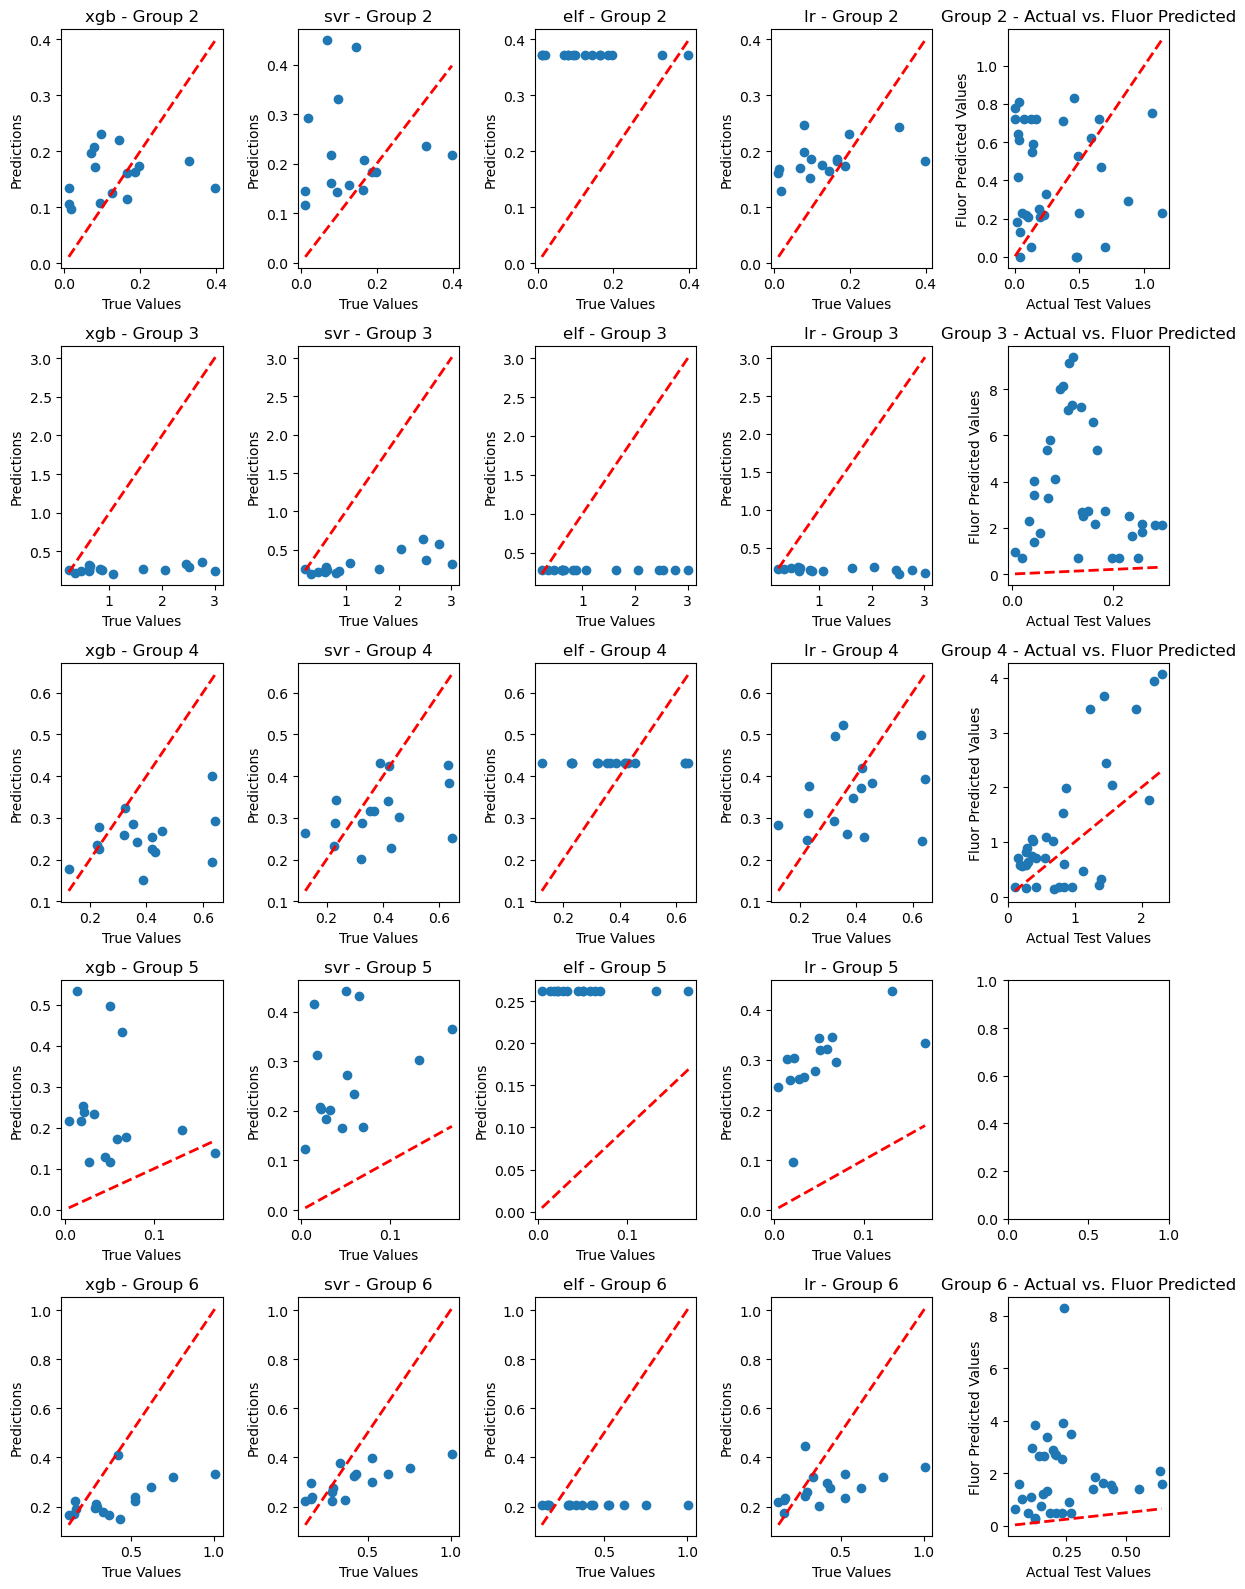

In [84]:
comparing_df = compare_all_models(regression_models, merged_val, fluor_test_df, fluor_groups_map, predictions_fn=np.exp)

In [85]:
comparing_df.groupby('Model').mean()[['RMSE', 'R-squared', 'MAPE']]

RMSE   R-squared       MAPE
Model                                 
FP     2.010829 -846.322364  16.578301
elf    0.460749   -6.098622   3.668016
lr     0.437637   -6.683940   2.836027
svr    0.412662   -6.269579   2.598410
xgb    0.434203   -6.470275   2.654896

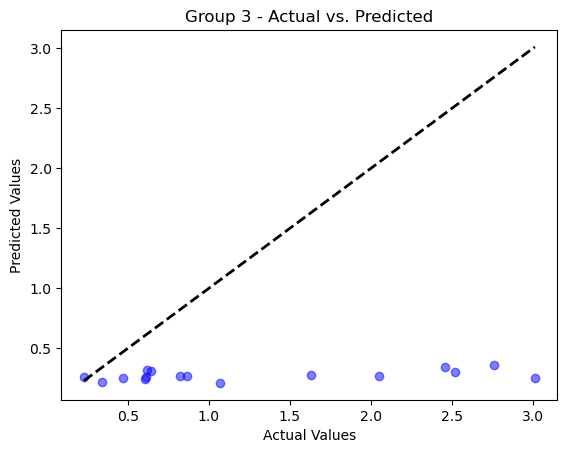

Results for group_num 3:
MSE: 1.8578404103496013
R-squared: -1.177062832363632



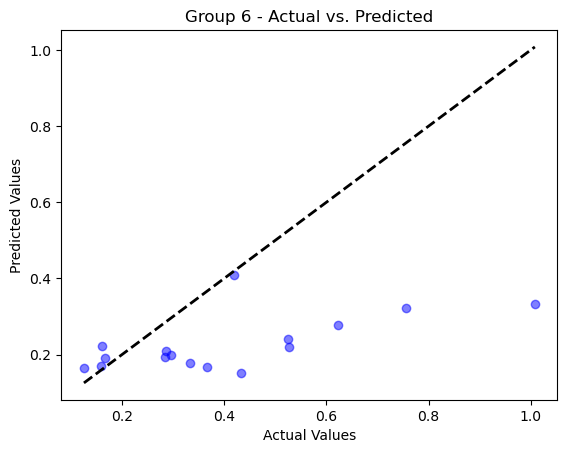

Results for group_num 6:
MSE: 0.06931728362830447
R-squared: -0.2800613311561584



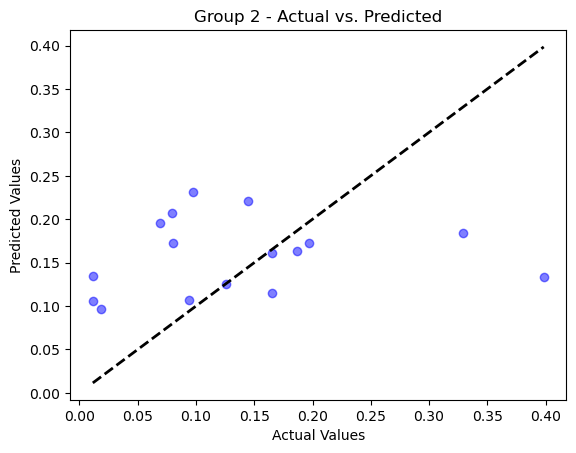

Results for group_num 2:
MSE: 0.011868307843706958
R-squared: -0.09679194435957639



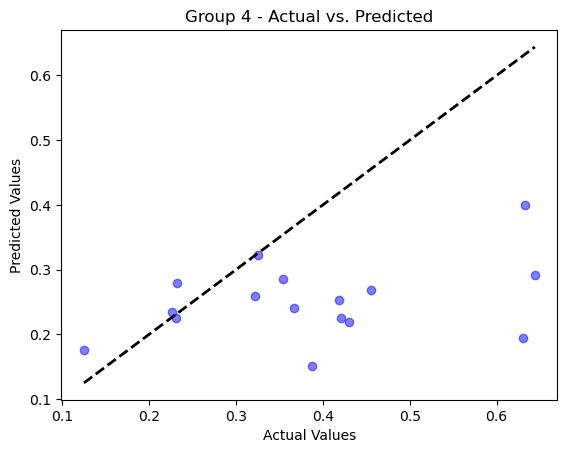

Results for group_num 4:
MSE: 0.03741761543977769
R-squared: -0.7248859232650673



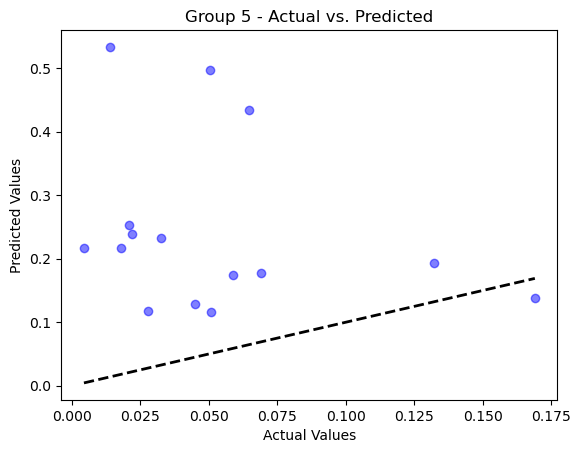

Results for group_num 5:
MSE: 0.05872217634330872
R-squared: -30.072573969576748

Total MSE: 0.4070331587209398, Total R-squared: -6.470275200144236


In [86]:
eval_test(regression_models['xgb'], merged_val, prediction_fn=np.exp)